### ANOMALY DETECTION IN FINANCIAL TRANSACTIONS FOR FRAUD IDENTIFICATION USING AUTOENCODERS AND RANDOM FOREST. BY CAIO O. QUINAMO

#### 0. INTRODUCTION

The advancement of digital commerce has opened new opportunities as well as new risks. Every day, millions of electronic transactions flow through payment platforms, and among them, many conceal sophisticated frauds that are difficult to detect using static rules. This project tackles this challenge by applying modern anomaly detection techniques to efficiently and automatically identify suspicious operations.

The solution is based on a hybrid architecture, combining semi-supervised and supervised learning: an autoencoder trained exclusively on legitimate transactions learns the normal structure of financial behavior; its inability to reconstruct atypical transactions generates a reconstruction error that becomes an alert signal. This error is then incorporated as a new variable into a Random Forest model, which can distinguish real frauds from false positives with greater accuracy.

This notebook is accompanied by a comprehensive technical report that develops all steps of the CRISP-DM methodology: from problem understanding and exploratory analysis, to data preparation, modeling, evaluation, and critical reflection on the results. The report complements the code with visualizations, motivation for the approach, design decisions, and detailed metric analysis.

You can consult the full report at the link below, where each section of the code aligns with the explanatory sections of the document:

<a href="https://raw.githubusercontent.com/caioquinamo/NDSPP.2025.0001.01.1/main/3.Report/1.TR.NDSPP.2025.0001.01.1.EN.pdf" download>Technical Report NDSPP/2025/0001-01-1 (Download)</a>

See the full project in GitHub:

[Repository NDSPP/2025/0001-01-1](https://github.com/caioquinamo/NDSPP.2025.0001.01.1)

#### 1. BUSINESS UNDERSTANDING

In a digital environment where trust is as valuable an asset as capital, companies managing online payments face a constant challenge: identifying and blocking fraudulent transactions without hindering the experience of legitimate users. The fight against fraud is not only a technical issue but a strategic necessity that directly impacts profitability, reputation, and business sustainability.

The main objective from a business perspective is to **reduce the economic and reputational impact of fraud while ensuring a high level of accuracy to avoid false positives that could block legitimate transactions**. In practical terms, this translates into developing a solution capable of detecting as many fraudulent transactions as possible, but with enough sensitivity to preserve the customer experience.

In this context, this project simulates the role of a data science team hired by a fintech company to enhance the efficiency of its fraud detection system, proposing a model that is adaptable, interpretable, and complementary to its current methods.

Online financial fraud represents a growing threat. Companies handling payments, e-commerce platforms, and digital banks are witnessing how cybercriminals' techniques are becoming more sophisticated. In light of this reality, standard solutions based on fixed rules are no longer sufficient.

The dataset used in this project reflects a realistic scenario of operations with a high degree of imbalance: fraudulent transactions account for a minority compared to the large volume of legitimate ones. This imbalance complicates the development of effective models, as algorithms tend to learn majority patterns. To address this, a combination of semi-supervised and supervised learning will be explored, allowing the project to leverage the best of both approaches.

The main analytical objective is to **build an anomaly detection model that can serve as an early warning system** for potentially fraudulent transactions. To achieve this:

* An autoencoder will be trained exclusively on legitimate transactions to learn the system's normal behavior.
* The autoencoder’s reconstruction error will be used as an indicator of deviation from normality.
* This error will be integrated as a new feature in a Random Forest model, which will be responsible for the final classification.

The model’s success will be evaluated primarily using two key metrics:

* **Area Under the Precision-Recall Curve (AUPRC)**, which is far more informative than ROC-AUC in scenarios where positives (frauds) are rare, as it focuses on the quality of predictions for the minority class.
* **F1 Score**, which balances precision and recall, especially useful in contexts with imbalanced classes.

These metrics will allow for a more realistic assessment of the system’s ability to detect fraud without severely penalizing the majority (legitimate) class.

The project development follows the CRISP-DM methodology, starting with problem understanding and progressing through to model evaluation. Although deployment is not addressed in this work, all prior steps are documented and justified with visualizations, reproducible code, and detailed analysis.

#### 2. DATA UNDERSTANDING

At this stage, the dataset consists exclusively of numerical variables, most of which result from a transformation using Principal Component Analysis (PCA). This gives the predictor variables an abstract nature, with no direct semantic interpretation, but with statistical properties that are useful for modeling.

Variables V1 to V28 represent these principal components. Since they are decorrelated by design, they provide a solid foundation for techniques such as autoencoders, which benefit from latent structures in the data. However, their abstract nature also necessitates a purely empirical approach, prioritizing the relationship between these variables and the target variable over domain-based interpretations.

In addition to the PCA-transformed variables, two untransformed features are included:

* **Amount:** the monetary value of the transaction. Its range and distribution require normalization to ensure proper handling by learning algorithms.
* **Time:** a temporal variable measuring the number of seconds elapsed since the start of the recording. Although it lacks real-time context, it may capture sequential patterns or behaviors associated with the time of day.

Finally, the **Class** variable serves as the binary label and is the target to be predicted. Its low rate of positive representation (fraud cases) renders conventional evaluation metrics inadequate, justifying the use of specialized metrics such as **AUPRC** and **F1 Score** in all subsequent phases.

##### IMPORT NECESSARY LIBRARIES

In [1]:
import gdown
import pandas as pd
import numpy as np

from IPython.display import HTML, display
from scipy import spatial

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import pipeline
from sklearn import feature_selection
from sklearn import ensemble
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

import warnings
import random

np.random.seed(4)
sns.set_style('dark')
warnings.simplefilter(action='ignore', category=FutureWarning)

##### ABOUT DATA

In [2]:
url = 'https://drive.google.com/uc?id=19ALFdJHV3ZehAZngdLBsoYtUZPOjunBY'
output = "DATASET NDSPP.2025.0001.01.1.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19ALFdJHV3ZehAZngdLBsoYtUZPOjunBY
From (redirected): https://drive.google.com/uc?id=19ALFdJHV3ZehAZngdLBsoYtUZPOjunBY&confirm=t&uuid=926cb471-7ff5-4e83-b157-b6e0cf708895
To: C:\Users\caioq\Google Drive\Mi unidad\Data Science\Jupyter Notebooks\6. Portfolio\Portfolio 3\1. NDSPP.2025.0001.01 (EN)\DATASET NDSPP.2025.0001.01.1.csv
100%|███████████████████████████████████████████████████████████████████████████████| 151M/151M [00:12<00:00, 11.8MB/s]


'DATASET NDSPP.2025.0001.01.1.csv'

In [3]:
rawdata = pd.read_csv(output)
data = rawdata.copy(deep=False)
data0, data1 = data[data['Class'] == 0], data[data['Class'] == 1]

In [4]:
# General Info
display(HTML("<h3 style=font-weight:bold; '>Data Info</h3>"))
print(data.info(verbose=False))

display(HTML("<h3 style=font-weight:bold; '>Duplicated Records</h3>"), data.duplicated().sum())
display(HTML("<h4 style=font-weight:bold; '>Data 0. Duplicated Records</h4>"), data0.duplicated().sum())

if data0.duplicated().sum() == 0:
    display(HTML("<h5 style=font-weight:bold; '>No duplicated records found</h5>"))
else:
    data0 = data0.drop_duplicates().reset_index(drop=True)
    display(HTML("<h5 style=font-weight:bold; '>Duplicated records removed successfully</h5>"))
display(HTML("<h4 style=font-weight:bold; '>Data 1. Duplicated Records</h4>"), data1.duplicated().sum())
display(HTML("<h5 style=font-weight:bold; '>Duplicated records will not be removed</h5>"))

display(HTML("<h3 style=font-weight:bold; '>Missing Values</h3>"))
nullcolumns = data.isnull().sum()[data.isnull().sum() > 0]
if nullcolumns.empty:
    display(HTML("<h5 style=font-weight:bold; '>No missing values were found</h5>"))
else:
    display(HTML("<h5 style=font-weight:bold; '>Missing values found in the following columns:</h5>"))
    print(nullcolumns)

data0 = data0.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Columns: 31 entries, Time to Class
dtypes: float64(30), int64(1)
memory usage: 67.4 MB
None


1081

1062

19

##### EXPLORATORY DATA ANALYSIS

###### ANALYSIS OF THE TARGET VARIABLE

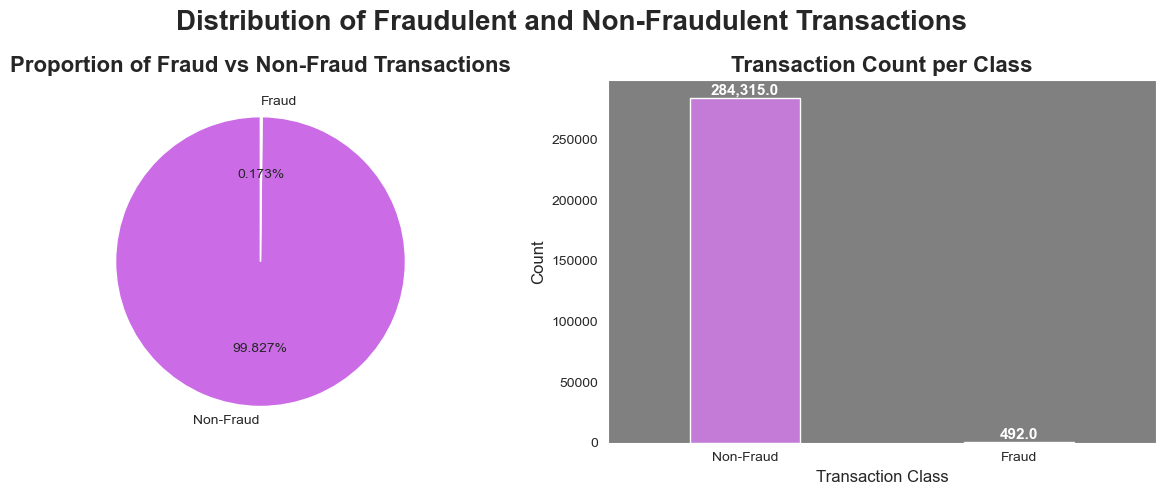

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
classdist = {'Non-Fraud': len(data0), 'Fraud': len(data1)}
x = ['Fraud' if val == 1 else 'Non-Fraud' for val in data['Class']]

axs[0].pie(x=list(classdist.values()), labels=list(classdist.keys()), colors=['#CB6CE6', 'white'], autopct='%1.3f%%', startangle=90)
axs[0].set_title('Proportion of Fraud vs Non-Fraud Transactions', size=16, weight='bold')

sns.countplot(data=data, x=x, width=0.4, palette=['#CB6CE6', 'white'], ax=axs[1])
axs[1].set_title('Transaction Count per Class', size=16, weight='bold'), axs[1].set_facecolor('grey')
axs[1].set_xlabel('Transaction Class', size=12), axs[1].set_ylabel('Count', size=12)

for p in axs[1].patches:
    height = p.get_height()
    axs[1].annotate(f'{height:,}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', size=11, weight='bold', color='w')

plt.suptitle('Distribution of Fraudulent and Non-Fraudulent Transactions', size=20, weight='bold'), plt.tight_layout();

###### CORRELATIONS WITH THE TARGET VARIABLE (BEFORE PRE-PROCESSING AND RECONSTRUCTION OF THE AUTOENCODER)

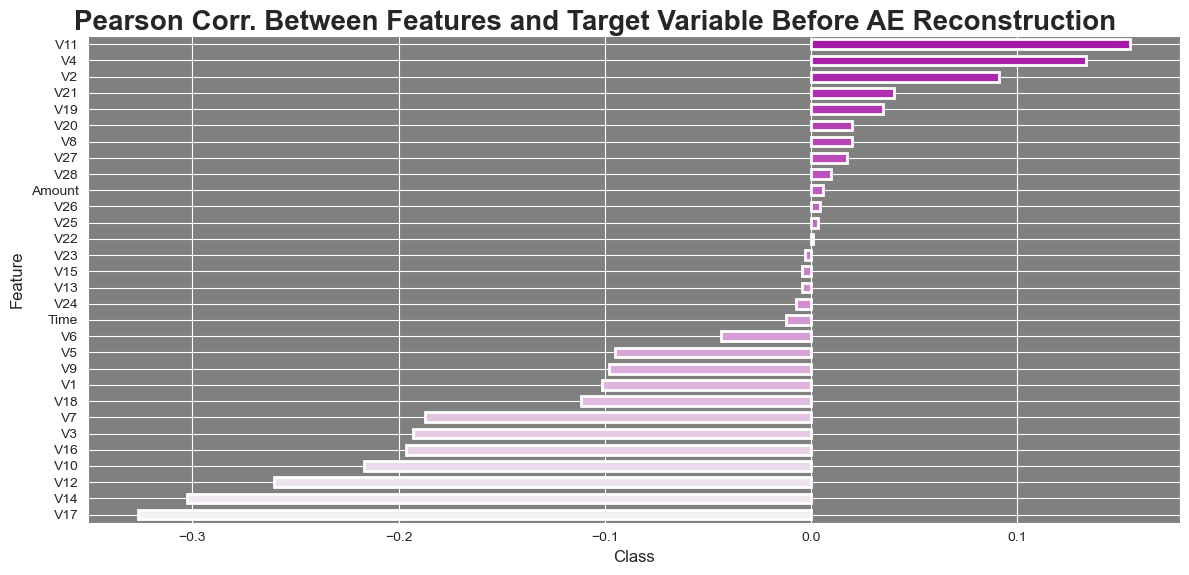

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = data.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=ax)

plt.xlabel('Class', size=12), plt.ylabel('Feature', size=12), ax.set_facecolor('grey'), plt.grid()
plt.suptitle('Pearson Corr. Between Features and Target Variable Before AE Reconstruction', size=20, weight='bold', y=0.95)
plt.tight_layout();

The chart shows the Pearson correlations between each feature and the target variable. As expected, the correlations are low: the features have been transformed using PCA, an unsupervised method that maximizes variance without considering the class. This explains the weak linear relationship with the **Class** variable. Negative correlations tend to be stronger in absolute value.

Interestingly, **Amount** and **Time**, the only non-anonymized variables, show very low correlation with the class. This suggests they should be analyzed separately in later stages.

###### UNIVARIATE ANALYSIS OF TIME AND AMOUNT

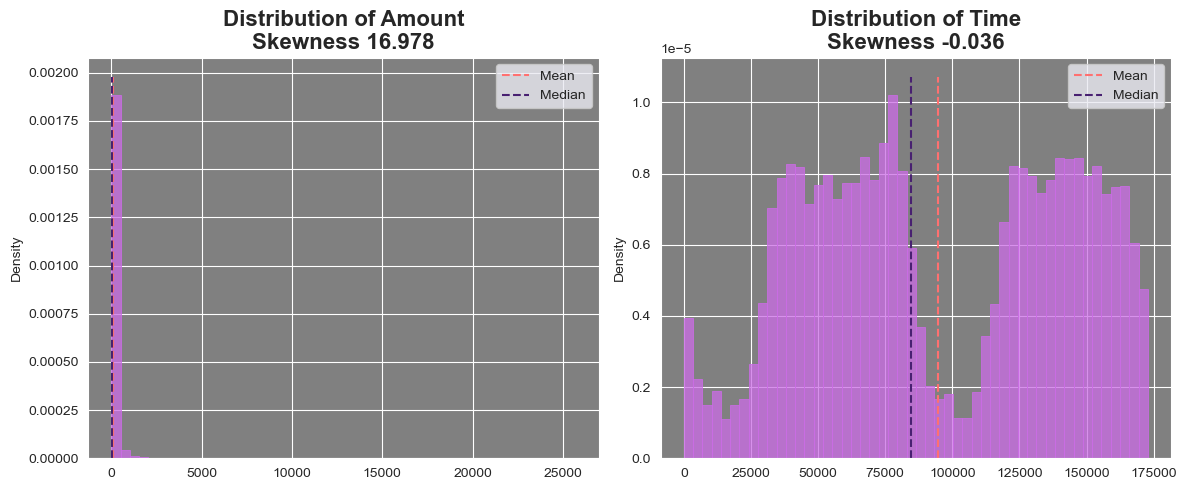

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, (col, ax) in enumerate(zip(data[['Amount', 'Time']].columns, axs.flat)):
    sns.histplot(data[col], bins=50, stat='density', edgecolor='#CB6CE6', color='#CB6CE6', ax=ax)
    ax.set_title(f'Distribution of {col}\nSkewness {data[col].skew():.3f}', size=16, weight='bold')
    ax.set_xlabel(None), ax.set_ylabel('Density', fontsize=10)
    
    ymin, ymax = ax.get_ylim()
    
    ax.vlines(x=data[col].mean(),   ymin=ymin, ymax=ymax, linestyles='--', colors='#FF7070', label='Mean')
    ax.vlines(x=data[col].median(), ymin=ymin, ymax=ymax, linestyles='--', colors='#482071', label='Median')
    ax.set_facecolor('grey'), ax.grid(), ax.legend()
    
plt.tight_layout();

**«Amount»**, in contrast, exhibits extreme positive skewness (skewness ≈ 16.978). Most transactions cluster around low values, while only a minority involve high amounts. This strong asymmetry could introduce bias into the model and negatively impact the learning process. Therefore, prior to training the autoencoder, an appropriate transformation will be applied to this feature to reduce the influence of outliers. Additionally, we already have two indicators (the Pearson coefficient and the skewness coefficient) suggesting that, in general, fraudulent transactions tend not to involve high amounts.

**«Time»** shows a relatively symmetrical distribution (skewness ≈ -0.036), indicating no significant skew. However, since it simply reflects the number of seconds since the first recorded transaction, it lacks direct interpretability in terms of transactional behavior. Its actual value to the model will be assessed to determine whether it contributes meaningful information or should be excluded to avoid introducing noise.

In [8]:
quantiles = [0.01, 0.50, 0.99]
summary = data1[['Amount', 'Time']].describe(quantiles)
summary.columns = summary.rename(columns={'Amount': 'Amount (Class 1)', 'Time': 'Time (Class 1)'}).columns
summary['Amount (Class 0)'], summary['Time (Class 0)'] = data0['Amount'].describe(quantiles), data0['Time'].describe(quantiles)
summary.loc['range'] = summary.loc['max'] - summary.loc['min']
style = summary.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Summary of Statistics for Amount and Time by Class</h3>"))
display(style)

,Amount (Class 1),Time (Class 1),Amount (Class 0),Time (Class 0)
count,492.000000,492.000000,283253.000000,283253.000000
mean,122.211321,80746.806911,88.413575,94835.058093
std,256.683288,47835.365138,250.379023,47475.550607
min,0.000000,406.000000,0.000000,0.000000
1%,0.000000,7525.370000,0.120000,2425.000000
50%,9.250000,75568.500000,22.000000,84711.000000
99%,1357.427900,167500.360000,1018.057600,170560.480000
max,2125.870000,170348.000000,25691.160000,172792.000000
range,2125.870000,169942.000000,25691.160000,172792.000000


In [9]:
statistics = {'Amount (Class 1)': summary['Amount (Class 1)'], 'Amount (Class 0)': summary['Amount (Class 0)'],
              'Time (Class 1)'  : summary['Time (Class 1)']  , 'Time (Class 0)'  : summary['Time (Class 0)']}
statistics = pd.DataFrame(statistics, index=['mean', '50%', 'std', 'range'])

amount = statistics[['Amount (Class 1)', 'Amount (Class 0)']].reset_index().melt(id_vars='index', value_name='Value')
time = statistics[['Time (Class 1)', 'Time (Class 0)']].reset_index().melt(id_vars='index', value_name='Value')
ranges = pd.concat([amount.loc[[3,7]].assign(Variable='Amount'), time.loc[[3,7]].assign(Variable='Time')]).reset_index(drop=True)

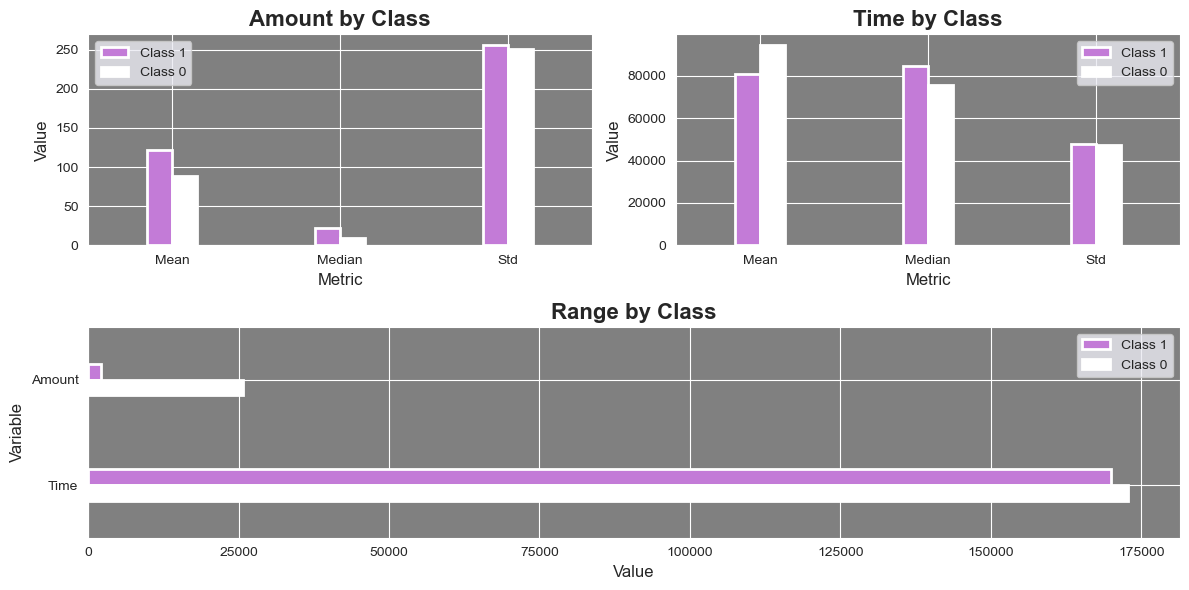

In [10]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, figure=fig)
hue = ['Class 1','Class 0','Class 1','Class 0', 'Class 1','Class 0']

ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=amount.drop([3, 7]), x='index', y='Value', hue=hue,
            width=0.3, edgecolor='white', linewidth=2, palette=['#CB6CE6', 'white'], ax=ax1)
ax1.set_title('Amount by Class', size=16, weight='bold')
ax1.set_xticks([0, 1, 2]), ax1.set_xticklabels(['Mean', 'Median', 'Std'])
ax1.set_xlabel('Metric', size=12), ax1.set_ylabel('Value', size=12), ax1.set_facecolor('grey'), ax1.grid()

ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(data=time.drop([3, 7]), x='index', y='Value', hue=hue,
            width=0.3, edgecolor='white', linewidth=2, palette=['#CB6CE6', 'white'], ax=ax2)
ax2.set_title('Time by Class', fontsize=16, weight='bold')
ax2.set_xticks([0, 1, 2]), ax2.set_xticklabels(['Mean', 'Median', 'Std'])
ax2.set_xlabel('Metric', size=12), ax2.set_ylabel('Value', size=12), ax2.set_facecolor('grey'), ax2.grid()

ax3 = fig.add_subplot(gs[1, :])
sns.barplot(data=ranges, x='Value', y='Variable', hue=['Class 1','Class 0','Class 1','Class 0'],
            width=0.3, edgecolor='white', linewidth=2, palette=['#CB6CE6', 'white'], ax=ax3)
ax3.set_title('Range by Class', size=16, weight='bold')
ax3.set_xlabel('Value', size=12), ax3.set_ylabel('Variable', size=12), ax3.set_facecolor('grey'), ax3.grid()
plt.tight_layout();

**«Amount»**: Although the mean in class 1 is higher, 50% of fraudulent transactions involve amounts below 9.25, indicating strong skewness. The maximum value of a non-fraudulent transaction is over 12 times greater than that of a fraudulent one (≈25,691 vs. ≈2,126). In class 1, the 99th percentile (1357) is significantly lower than the maximum (2125), suggesting that outliers have a considerable impact on the mean.


**«Time»**: The mean of **Time** is lower in class 1, which may indicate that frauds tend to occur more frequently at the beginning of the recorded period. The range of **Time** is similar across both classes, but the median in class 1 (≈75,568) is somewhat lower than in class 0 (≈84,711), possibly reflecting a temporal pattern in fraud attempts. As a personal criterion and due to its low representativeness, **Time** has been excluded from both the analysis and the predictive model, as it is considered to have little influence on fraud detection.

###### 2D DATA VISUALISATION (BEFORE PREPROCESSING AND AUTOENCODER RECONSTRUCTION)

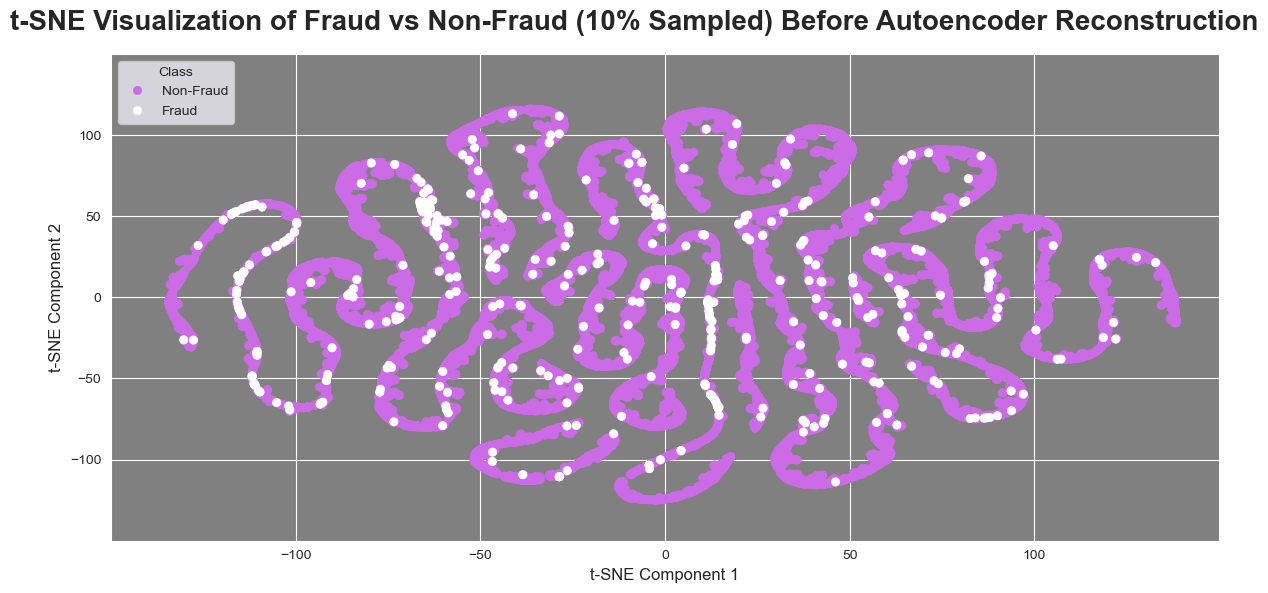

In [11]:
np.random.seed(4)
tsne = manifold.TSNE(n_components=2, random_state=4, n_jobs=-1)

fig, ax = plt.subplots(figsize=(12, 6))

plotdata0 = data0.iloc[np.random.choice(data0.shape[0], int(len(data0) * 0.10), replace=False)]
plotdata = pd.concat([plotdata0, data1], axis=0).reset_index(drop=True)
Xsampled, ysampled = plotdata.drop(['Class'], axis=1).values, plotdata["Class"].values

tsnebefore = tsne.fit_transform(Xsampled)
xtsnebefore, ytsnebefore = tsnebefore[:,0], tsnebefore[:,1]
huebefore = pd.Series(ysampled).replace({0:'Non-Fraud', 1:'Fraud'})

sns.scatterplot(x=xtsnebefore, y=ytsnebefore, hue=huebefore, palette=['#CB6CE6', 'white'], edgecolor=None)
plt.grid(), ax.set_facecolor('grey'), plt.legend(title='Class', loc='upper left')
plt.xlim(-150, 150), plt.xticks([-100, -50, 0, 50, 100]), plt.ylim(-150, 150), plt.yticks([-100, -50, 0, 50, 100])
plt.xlabel('t-SNE Component 1', size=12), plt.ylabel('t-SNE Component 2', size=12)
plt.suptitle('t-SNE Visualization of Fraud vs Non-Fraud (10% Sampled) Before Autoencoder Reconstruction', size=20, weight='bold')
plt.tight_layout();

t-SNE plot applied to a 10% sample of the original dataset. Although a clear separation between the two classes is not observed, certain areas with a local concentration of fraud cases can be identified, suggesting the presence of latent patterns. This visualization supports the decision to use an autoencoder model to generate an internal representation that facilitates class separation within a latent space optimized for anomaly detection.


###### UNIVARIATE OUTLIER DETECTION VIA Z-SCORE STANDARDIZATION

In [12]:
def zscores(data):
    data = data.select_dtypes(include='number')
    for col in data.columns:
        z_score = (data[col] - data[col].mean()) / data[col].std()
        data[f'{col} (Z-Score)'] = z_score
    return data

zscore = zscores(data)
zscore = zscore.iloc[:, zscore.shape[1] // 2:-1].reset_index(drop=True)
zscore['Class'] = data['Class']
zscore['Outlier'] = (zscore.drop('Class', axis=1).abs() > 3).any(axis=1).astype(int)

In [13]:
pca = decomposition.PCA(n_components=2, random_state=4)
Xpca = pca.fit_transform(zscore.drop(['Class', 'Outlier'], axis=1))
dfpca = pd.DataFrame(Xpca, columns=['PCA 1', 'PCA 2'])
dfpca['Outlier'] = zscore['Outlier']
dfpca['Class'] = data['Class']

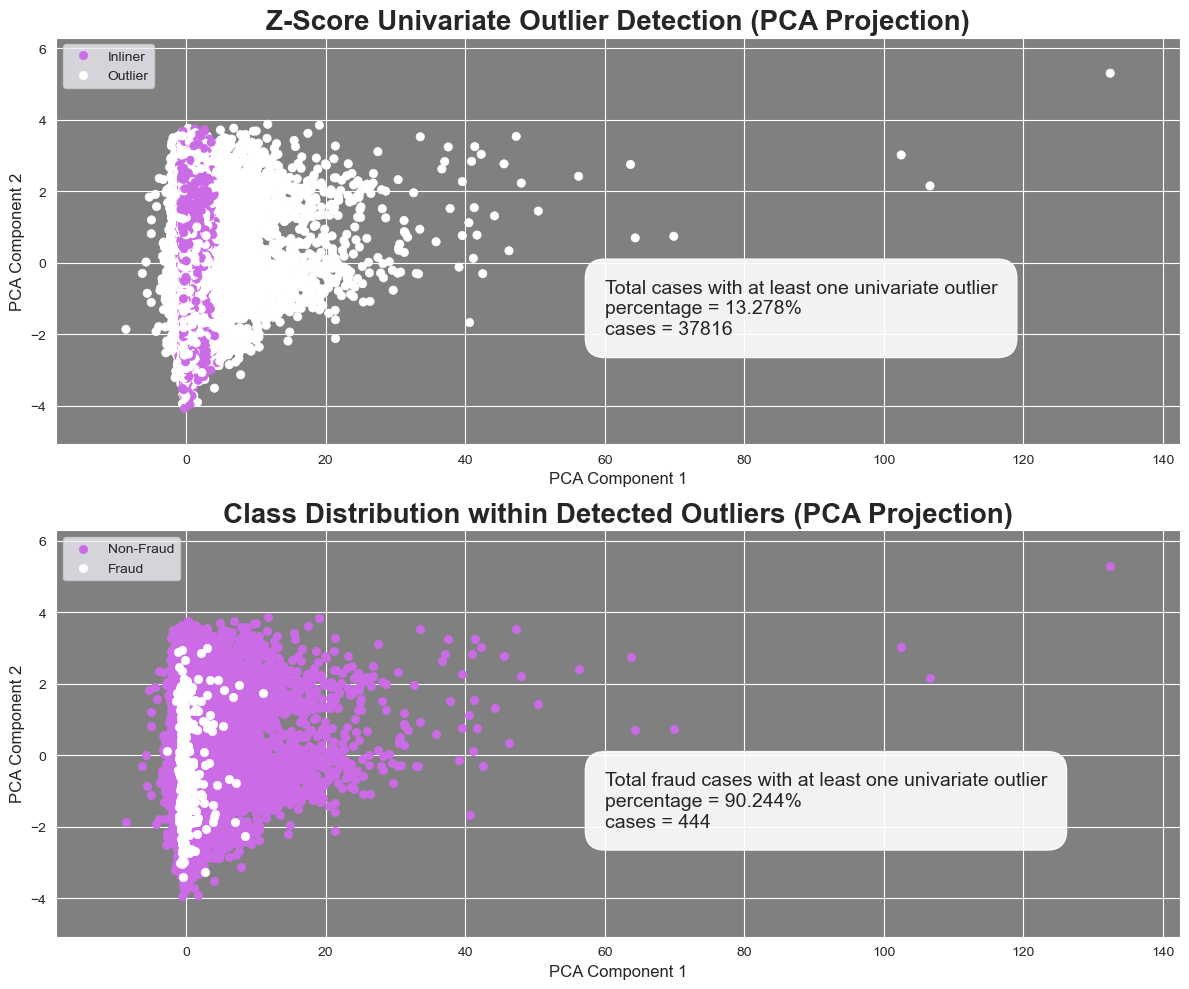

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

x, y = dfpca['PCA 1'], dfpca['PCA 2']
hue = ['Outlier' if val == 1 else 'Inliner' for val in zscore['Outlier']]
outliers = dfpca[dfpca['Outlier'] == 1].reset_index(drop=True)
nonfraud, fraud = outliers[outliers["Class"] == 0].reset_index(drop=True), outliers[outliers["Class"] == 1].reset_index(drop=True)

sns.scatterplot(x=x, y=y, edgecolor=None, hue=hue, palette=['#CB6CE6', 'white'], ax=axs[0])

outp0 = zscore[zscore['Outlier'] == 1].shape[0] / data.shape[0] * 100
str = f'Total cases with at least one univariate outlier\npercentage = {outp0:.3f}%\ncases = {len(outliers)}'
axs[0].text(60, -2, str, size=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round,pad=1'))

axs[0].set_xlim(min(x - 10), max(x + 10)), axs[0].set_ylim(min(y - 1), max(y + 1)), axs[0].set_facecolor('grey'), axs[0].grid()
axs[0].set_xlabel('PCA Component 1', size=12), axs[0].set_ylabel('PCA Component 2', size=12), axs[0].legend()
axs[0].set_title('Z-Score Univariate Outlier Detection (PCA Projection)', size=20, weight='bold')

sns.scatterplot(x=nonfraud['PCA 1'], y=nonfraud['PCA 2'], edgecolor=None, color='#CB6CE6', label='Non-Fraud', ax=axs[1])
sns.scatterplot(x=fraud['PCA 1'], y=fraud['PCA 2'], edgecolor=None, color='white', label='Fraud', ax=axs[1])

outp1 = outliers[outliers['Class'] == 1].shape[0] / data1.shape[0] * 100
str = f'Total fraud cases with at least one univariate outlier\npercentage = {outp1:.3f}%\ncases = {len(outliers[outliers["Class"] == 1])}'
axs[1].text(60, -2, str, size=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round, pad=1'))

axs[1].set_xlim(min(x - 10), max(x + 10)), axs[1].set_ylim(min(y - 1), max(y + 1)), axs[1].set_facecolor('grey'), axs[1].grid()
axs[1].set_xlabel('PCA Component 1', size=12), axs[1].set_ylabel('PCA Component 2', size=12), axs[1].legend()
axs[1].set_title('Class Distribution within Detected Outliers (PCA Projection)', size=20, weight='bold')
plt.tight_layout();

**Z-Score Univariate Outlier Detection (PCA Projection):** It can be observed that these outliers are distributed along the main dimension and do not cluster in a specific region of the projected space. This suggests that univariate outliers can arise in any part of the multivariate data domain.

**Class Distribution within Detected Outliers (PCA Projection):** This visualization shows how classes are distributed within the set of univariate outliers. The results reveal that 90.244% of fraud cases exhibit at least one outlier variable, indicating that most detected frauds show some univariate anomaly. However, there is also a significant number of legitimate (non-fraud) transactions that exhibit at least one feature outside the typical range.

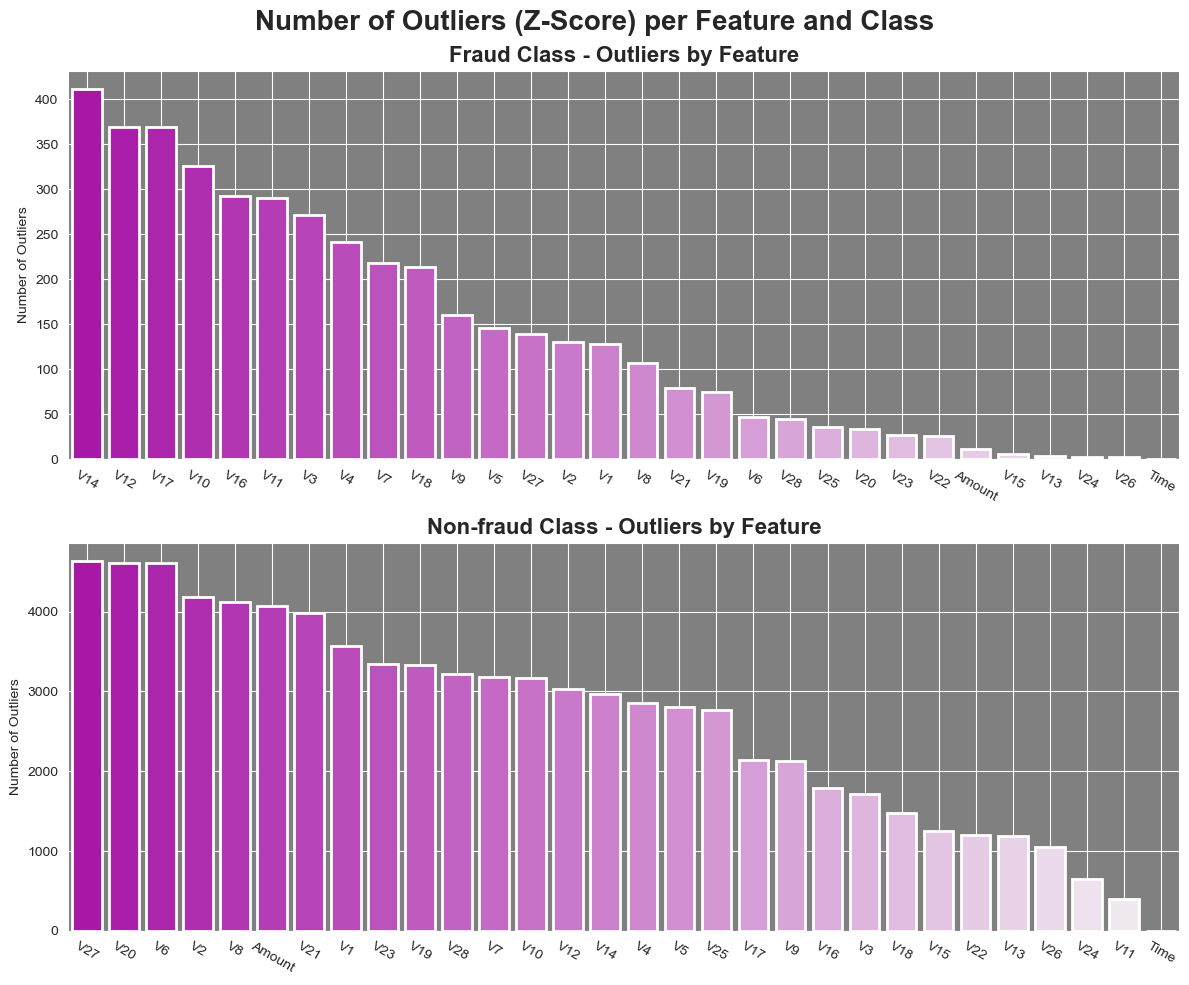

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

test1 = zscore[(zscore['Class'] == 1) & (zscore['Outlier'] == 1)].reset_index(drop=True)
test1 = test1.drop(['Class', 'Outlier'], axis=1)
test1.columns = test1.columns.str.replace(' (Z-Score)', '', regex=False)

fraudcounts = {}
for col in test1.columns:
    count = ((test1[col] > 3) | (test1[col] < -3)).sum()
    fraudcounts[col] = count
fraudcounts = dict(sorted(fraudcounts.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(fraudcounts.keys()), y=list(fraudcounts.values()),
            palette='light:m_r', edgecolor='white', linewidth=2, ax=ax1)
ax1.tick_params(axis='x', rotation=-30), ax1.set_facecolor('grey'), ax1.grid()
ax1.set_xlabel(None), ax1.set_ylabel('Number of Outliers')
ax1.set_title('Fraud Class - Outliers by Feature', size=16, weight='bold')

test0 = zscore[(zscore['Class'] == 0) & (zscore['Outlier'] == 1)].reset_index(drop=True)
test0 = test0.drop(['Class', 'Outlier'], axis=1)
test0.columns = test0.columns.str.replace(' (Z-Score)', '', regex=False)

nonfraudcounts = {}
for col in test0.columns:
    count = ((test0[col] > 3) | (test0[col] < -3)).sum()
    nonfraudcounts[col] = count
nonfraudcounts = dict(sorted(nonfraudcounts.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(nonfraudcounts.keys()), y=list(nonfraudcounts.values()),
            palette='light:m_r', edgecolor='white', linewidth=2, ax=ax2)
ax2.tick_params(axis='x', rotation=-30), ax2.set_facecolor('grey'), ax2.grid()
ax2.set_xlabel(None), ax2.set_ylabel('Number of Outliers')
ax2.set_title('Non-fraud Class - Outliers by Feature', size=16, weight='bold')
fig.suptitle('Number of Outliers (Z-Score) per Feature and Class', size=20, weight='bold')
plt.tight_layout();

In the fraud class, a strong concentration of outliers is observed in variables such as **V14**, **V12**, **V17**, and **V10**, which also show the highest absolute correlation coefficients with the target variable. This overlap reinforces the idea that certain dimensions are not only statistically associated with fraud but also tend to exhibit extreme anomalous behavior in such cases.

In contrast, for the non-fraudulent class, outliers are also present but are more evenly distributed across variables that do not show a strong correlation with the class. This suggests that not every outlier indicates fraud, but many fraudulent transactions are indeed characterized by outliers in a specific subset of key variables.

Taken together, this relationship between high correlation and frequent statistical anomalies indicates that these variables are not only predictive but also strong candidates for individual monitoring or for guiding reconstruction processes, such as the one to be performed with the autoencoder.

###### MULTIVARIATE OUTLIER DETECTION VIA MAHALANOBIS DISTANCE

In [16]:
Xzscore  = zscore.drop('Class', axis=1)
center = Xzscore.mean()
cov = np.cov(Xzscore.T)
invcov = np.linalg.inv(cov)
zscore['Mahal'] = Xzscore.apply(lambda x: spatial.distance.mahalanobis(x, center, invcov), axis=1)

threshold = np.percentile(zscore['Mahal'], 99.9) ## Elegido según el criterio del analista

zscore['Outlier'] = (zscore['Mahal'] > threshold).astype(int)
dfpca = pd.DataFrame(pca.fit_transform(Xzscore), columns=['PCA 1', 'PCA 2'])

dfpca['Outlier'] = zscore['Outlier'].values
dfpca['Class'] = data['Class'].values

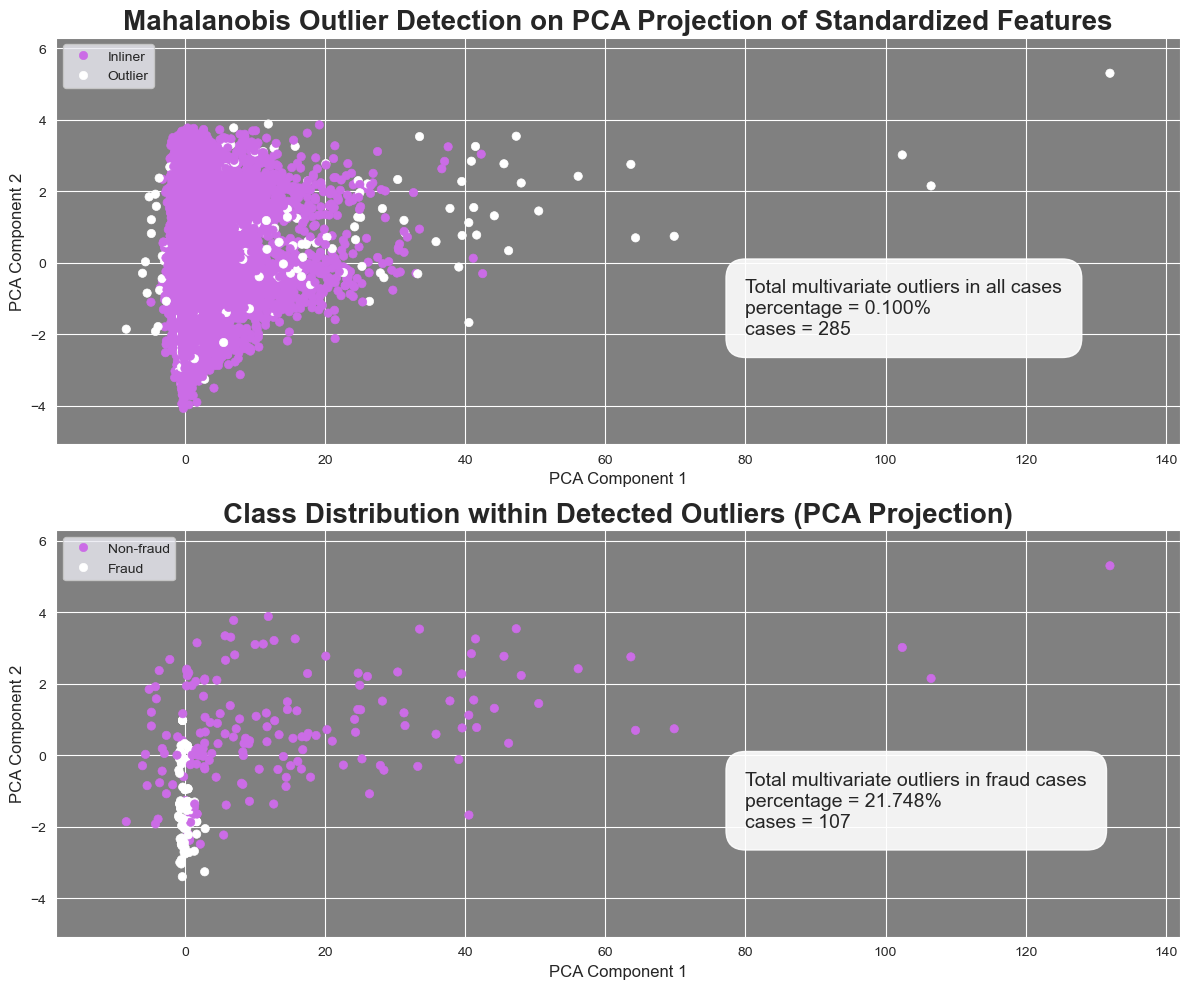

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

x0, y0 = dfpca['PCA 1'], dfpca['PCA 2']
hue0 = ['Outlier' if val == 1 else 'Inliner' for val in dfpca['Outlier']]
outliers = dfpca[dfpca['Outlier'] == 1]

# GRÁFICO 1
sns.scatterplot(x=x0, y=y0, edgecolor=None, hue=hue0, palette=['#CB6CE6', 'white'], ax=axs[0])

outp0 = outliers.shape[0] / data.shape[0] * 100
str = f'Total multivariate outliers in all cases\npercentage = {outp0:.3f}%\ncases = {len(outliers)}'
axs[0].text(80, -2, str, size=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round,pad=1'))

axs[0].set_xlim(min(x0 - 10), max(x0 + 10)), axs[0].set_ylim(min(y0 - 1), max(y0 + 1)), axs[0].set_facecolor('grey'), axs[0].grid()
axs[0].set_xlabel('PCA Component 1', size=12), axs[0].set_ylabel('PCA Component 2', size=12), axs[0].legend()
axs[0].set_title('Mahalanobis Outlier Detection on PCA Projection of Standardized Features', size=20, weight='bold')

# GRÁFICO 2
x1, y1 = outliers['PCA 1'], outliers['PCA 2']
hue1 = ['Fraud' if val == 1 else 'Non-fraud' for val in outliers['Class']]

sns.scatterplot(x=x1, y=y1, edgecolor=None, hue=hue1, palette=['#CB6CE6', 'white'], ax=axs[1])

outp1 = outliers[outliers['Class'] == 1].shape[0] / data1.shape[0] * 100
str = f'Total multivariate outliers in fraud cases\npercentage = {outp1:.3f}%\ncases = {len(outliers[outliers["Class"] == 1])}'
axs[1].text(80, -2, str, size=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round, pad=1'))

axs[1].set_xlim(min(x0 - 10), max(x0 + 10)), axs[1].set_ylim(min(y0 - 1), max(y0 + 1)), axs[1].set_facecolor('grey'), axs[1].grid()
axs[1].set_xlabel('PCA Component 1', size=12), axs[1].set_ylabel('PCA Component 2', size=12), axs[1].legend()
axs[1].set_title('Class Distribution within Detected Outliers (PCA Projection)', size=20, weight='bold')
plt.tight_layout();

Approximately **22% of fraudulent cases** have been detected as **multivariate outliers**, which is expected given that **most fraudulent transactions aim to blend in with normal behavior**. Especially when the amounts or patterns associated with fraud are not extreme, their detection through multivariate statistical methods becomes more challenging. The **Mahalanobis distance** is a technique used to identify global outliers based on a linear metric that is sensitive to joint deviation from the multivariate mean. However, it does not effectively capture **local anomalies, contextual patterns, or non-linear relationships**, such as transactions that would only be anomalous within an individual user’s profile or those that subtly affect only a few key variables.

This behavior is clearly illustrated in the **PCA-projected plots**. In the first, the global distribution of observations is visualized, where only **0.1% of all transactions** were labeled as outliers by Mahalanobis. Despite the small percentage, these observations are partially located outside the main data concentration, suggesting that they structurally differ from general behavior.

In the second plot, it becomes evident that **most fraud cases do not exhibit significant multivariate deviation**, confirming that Mahalanobis is not effective at detecting subtle or context-specific fraud. Due to the high class imbalance, generic outlier detection methods tend to be either conservative (detecting few outliers) or prone to generating false positives, as seems to be the case with Mahalanobis in this scenio.


#### 3. DATA PREPARATION

During the preparation phase, the **Time variable was removed** as it does not provide relevant predictive value and is more related to the order in which transactions were collected than to their intrinsic characteristics. On the other hand, the Amount variable, as previously discussed, exhibited a **high skewness coefficient**, indicating a heavily right-skewed distribution. To correct this skewness and prevent it from negatively affecting model performance, a **QuantileTransformer** with a uniform distribution was applied, allowing the variable to be transformed into a form closer to a symmetric and homogeneous distribution.

After this targeted transformation on **Amount**, a **MinMaxScaler normalization** was applied to the entire set of features. This decision aims to **standardize the scale** of the data, especially in preparation for training the autoencoder, whose performance is sensitive to differences in variable magnitudes.

It is worth noting that, in later stages of the workflow, the reconstruction error generated by the autoencoder will be used as a **new predictive variable** within a **Random Forest-based** classification model. This strategy allows the explicit incorporation of the structural anomaly of an observation as a complementary indicator to the rest of the original features.

<center>
  <img src="https://raw.githubusercontent.com/caioquinamo/NDSPP.2025.0001.01.1/main/4.Images/FIGURE1.png" width="1000">
</center>

In [18]:
mms = preprocessing.MinMaxScaler()
qtt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=4)
data0, data1 = data0.drop('Time', axis=1), data1.drop('Time', axis=1)

X0, y0 = data0.drop(columns='Class'), data0['Class'] ## Non-fraud
X0train, X0test, y0train, y0test =     model_selection.train_test_split(X0, y0, test_size=0.30, random_state=4)
X0test, X0val, y0test, y0val = model_selection.train_test_split(X0test, y0test, test_size=0.30, random_state=4)
X0train['Amount'], X0test['Amount'] = qtt.fit_transform(X0train[['Amount']]), qtt.transform(X0test[['Amount']])
X0train, X0test = mms.fit_transform(X0train), mms.transform(X0test)

X1, y1 = data1.drop(columns='Class'), data1['Class'] ## Fraud
X1test, X1val, y1test, y1val = model_selection.train_test_split(X1, y1, test_size=0.30, random_state=4)
X1test['Amount'] = qtt.transform(X1test[['Amount']])
X1test = mms.transform(X1test)

#### 4. MODELING

##### **AUTOENCODER**

An autoencoder is a neural network designed to learn a compressed representation of data, with the goal of reconstructing the original inputs as accurately as possible. Its training is unsupervised, as it uses the same inputs as target outputs. The model consists of two parts:

* **Encoder:** transforms the original data into a low-dimensional representation, capturing its most relevant internal patterns and structures.
* **Decoder:** attempts to reconstruct the original data from that compressed representation.

The loss function, in this case the **Mean Squared Error (MSE)**, measures the difference between the input data and its reconstruction. By minimizing this error during training, the autoencoder learns the regularities of the dataset. When trained exclusively on non-fraudulent examples (class 0), the model becomes effective at detecting anomalous transactions, as it will struggle to accurately reconstruct those that deviate from normal behavior, leading to a higher reconstruction error.

The chosen architecture is designed to strike a balance between **representation capacity and regularization**. Several dense layers with a decreasing number of neurons have been used in the encoder, which forces the model to learn a compressed representation that retains essential information. The use of **tanh activation functions** allows for modeling complex non-linear relationships without saturating as quickly as the sigmoid function, and **Dropout layers** introduce noise during training, improving generalization and reducing overfitThe decoder mirrors this structure symmetrically, with the goal of reconstructing the data from the latent space. Finally, **the output layer uses a ReLU activation**, which helps keep the outputs within the non-negative range during training. This is reasonable given that the data has been previously normalized using a **MinMaxScaler** fitted exclusively on the training set, which places the values within the 0 to 1 range.

However, since the model may later receive data that does not strictly follow this distribution (for example, anomalous inputs with values **slightly above 1 or below 0**), the use of ReLU could limit the model’s ability to properly reconstruct such cases, as it zeros out any negative value. In this context, other activations such as the sigmoid (which bounds the output between 0 and 1), or even a linear activation, could also be valid options if the goal is to allow outputs outside the range during reconstruction.

In [19]:
np.random.seed(4), random.seed(4), tf.random.set_seed(4)

class Autoencoder(keras.models.Model):
    def __init__(self, inputdim):
        super(Autoencoder, self).__init__()
        self.encoder = keras.Sequential([
            keras.layers.Input(shape=(inputdim,)),
            keras.layers.Dense(128, activation='tanh'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(64, activation='tanh'),
            keras.layers.Dropout(0.3)
        ]) ## Coding layer
        self.decoder = keras.Sequential([
            keras.layers.Input(shape=(64,)),
            keras.layers.Dense(128, activation='tanh'),
            keras.layers.Dense(64, activation='tanh'),
            keras.layers.Dense(inputdim, activation='relu')
        ]) ## Decoding layer (symmetrical structure)
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiation and compilation
inputdim = X0train.shape[1]
autoencoder = Autoencoder(inputdim)
autoencoder.compile(optimizer='adam', loss='mse')

# Training phase
history = autoencoder.fit(X0train, X0train, epochs=25, batch_size=256, shuffle=True, validation_split=0.3, verbose=1)

Epoch 1/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0540 - val_loss: 0.0302
Epoch 2/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0301 - val_loss: 0.0299
Epoch 3/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 4/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 5/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 6/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - val_loss: 0.0298
Epoch 7/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 8/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0299 - val_loss: 0.0298
Epoch 9/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0296 - val_loss: 0.0153
Epoch 10/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 11/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 12/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

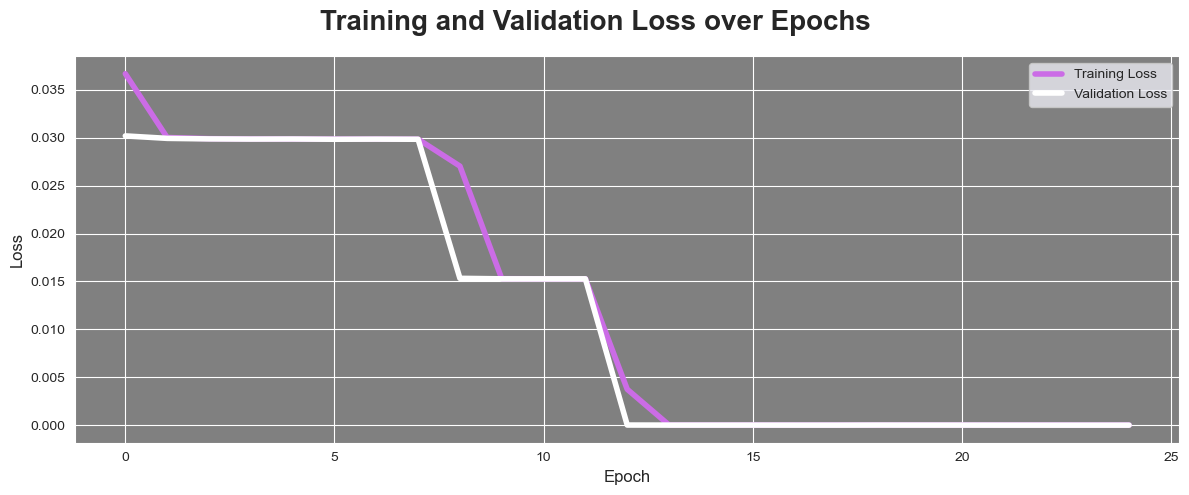

In [20]:
fig, axs = plt.subplots(figsize=(12, 5))

plt.plot(history.history['loss'], label='Training Loss', c='#CB6CE6', linewidth=4)
plt.plot(history.history['val_loss'], label='Validation Loss', c='white', linewidth=4)
axs.set_xlabel('Epoch', size=12), axs.set_ylabel('Loss', size=12)
plt.suptitle('Training and Validation Loss over Epochs', size=20, weight='bold')
axs.set_facecolor('grey'), axs.grid(True), plt.legend(), plt.tight_layout();

At the beginning, both curves drop rapidly, indicating that the autoencoder is effectively learning to reconstruct the data. Starting from epoch 13, the loss reaches an almost negligible level and remains stable until the end of training. This behavior suggests early and solid convergence, with no signs of overfitting, as the validation loss stays aligned with (or even lower than) the training loss. The result is a model that has learned efficiently and generalizes well to unseen data.


###### RECONSTRUCTION ERROR

In [21]:
Xencoded = autoencoder.encoder(np.concatenate([X0test, X1test]))
Xdecoded = autoencoder.decoder(Xencoded.numpy())

Rerror = np.mean(np.square(np.concatenate([X0test, X1test]) - Xdecoded), axis=1).reshape(-1,1)

Xmodel = np.concatenate([Xdecoded, Rerror], axis=1)
ymodel = np.concatenate([y0test, y1test])

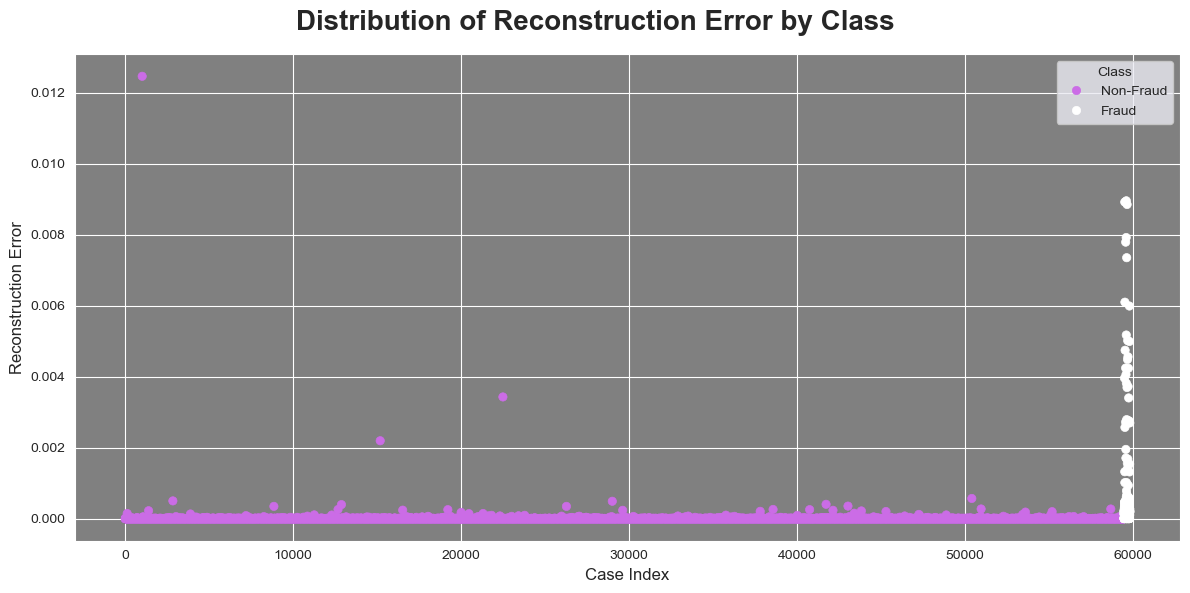

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
hue = np.where(ymodel == 1, 'Fraud', 'Non-Fraud')

sns.scatterplot(x=range(0, len(Xmodel)), y=Xmodel[:, -1], hue=hue,  palette=['#CB6CE6', 'white'], edgecolor=None)
plt.xlabel('Case Index', fontsize=12), plt.ylabel('Reconstruction Error', fontsize=12)
plt.suptitle('Distribution of Reconstruction Error by Class', fontsize=20, fontweight='bold')
ax.set_facecolor('grey'), plt.grid(), plt.legend(title='Class'), plt.tight_layout();

Most legitimate transactions have very low reconstruction errors, while fraudulent transactions have higher errors. This shows that the autoencoder distinguishes normal patterns well and that reconstruction error is an effective feature for detecting fraud.

In [23]:
columns = list(data.columns.drop(['Time', 'Class']))
columns.append('R. Error')
datamodel = pd.DataFrame(Xmodel, columns=columns)
datamodel['Class'] = ymodel
datamodel0, datamodel1 = datamodel[datamodel['Class'] == 0], datamodel[datamodel['Class'] == 1]

###### CORRELATIONS WITH THE TARGET VARIABLE (AFTER PREPROCESSING AND RECONSTRUCTION OF THE AUTOENCODER)

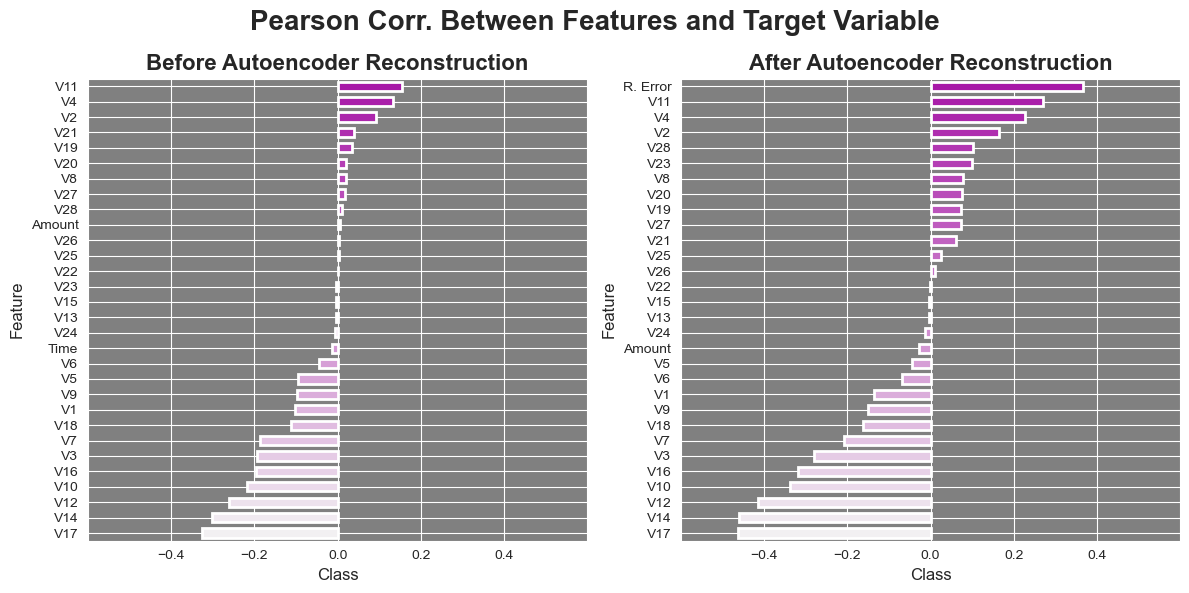

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
corr = data.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=axs[0])

axs[0].set_xlabel('Class', fontsize=12), axs[0].set_ylabel('Feature', fontsize=12), axs[0].set_facecolor('grey'), axs[0].grid()
axs[0].set_xlim(-0.6, 0.6), axs[0].set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
axs[0].set_title('Before Autoencoder Reconstruction', size=16, weight='bold')

corr = datamodel.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=axs[1])

axs[1].set_xlabel('Class', fontsize=12), axs[1].set_ylabel('Feature', fontsize=12), axs[1].set_facecolor('grey'), axs[1].grid()
axs[1].set_title('After Autoencoder Reconstruction', size=16, weight='bold')
axs[1].set_xlim(-0.6, 0.6), axs[1].set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
plt.suptitle('Pearson Corr. Between Features and Target Variable', size=20, weight='bold')
plt.tight_layout();

On the left, most features show very low correlation, indicating that individually they have little direct predictive power. On the right, after applying the autoencoder and computing the **reconstruction error** as a new variable **(R. Error)**, a significant change becomes evident: the reconstruction error now shows one of the highest correlations with the target variable. This confirms that the autoencoder has successfully captured relevant anomaly patterns that were previously diluted in the original data, thereby enhancing the model's discriminative power. Additionally, some variables such as **V11**, **V4**, and **V2** also increase their correlation, suggesting that the reconstruction process may have amplified useful signals for the fraud detection task.


###### 2D DATA VISUALISATION (AFTER PREPROCESSING AND AUTOENCODER RECONSTRUCTION)

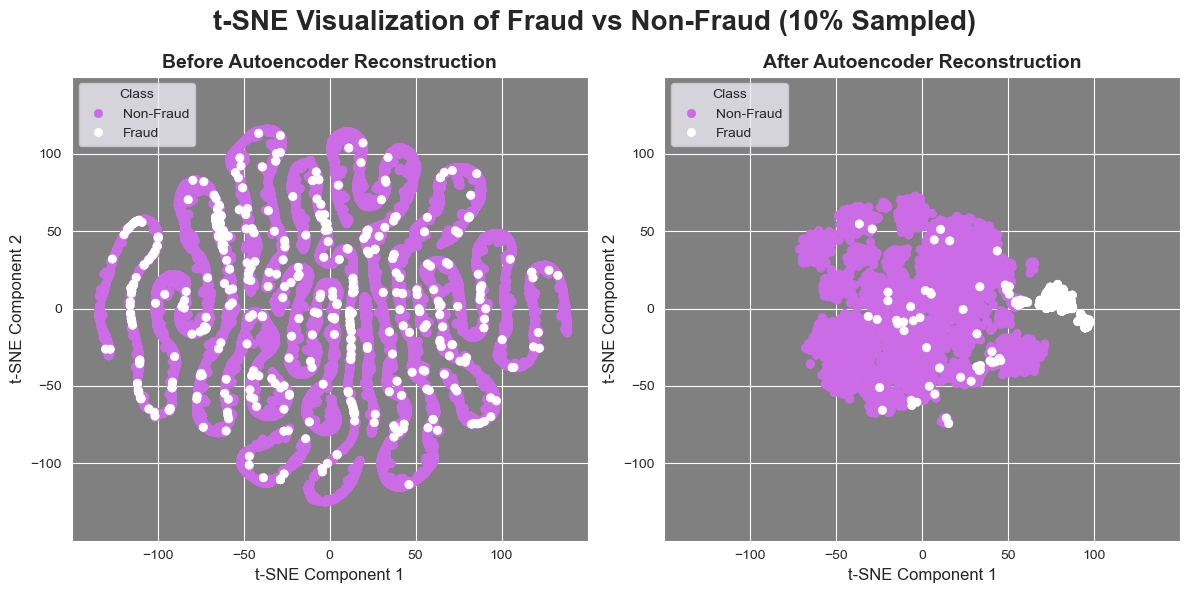

In [25]:
np.random.seed(4)
tsne = manifold.TSNE(n_components=2, random_state=4, n_jobs=-1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plotdata0 = datamodel0.iloc[np.random.choice(datamodel0.shape[0], int(len(datamodel0) * 0.10), replace=False)]
plotdata = pd.concat([plotdata0, datamodel1], axis=0).reset_index(drop=True)
Xsampled, ysampled = plotdata.drop(['Class'], axis=1).values, plotdata["Class"].values

tsneafter = tsne.fit_transform(Xsampled)
xtsneafter, ytsneafter = tsneafter[:,0], tsneafter[:,1]
hueafter = pd.Series(ysampled).replace({0:'Non-Fraud', 1:'Fraud'})

sns.scatterplot(x=xtsnebefore, y=ytsnebefore, hue=huebefore, palette=['#CB6CE6', 'white'], edgecolor=None, ax=axs[0])
axs[0].grid(), axs[0].set_facecolor('grey'), axs[0].legend(title='Class', loc='upper left')
axs[0].set_xlim(-150, 150), axs[0].set_xticks([-100, -50, 0, 50, 100]), axs[0].set_ylim(-150, 150), axs[0].set_yticks([-100, -50, 0, 50, 100])
axs[0].set_xlabel('t-SNE Component 1', size=12), axs[0].set_ylabel('t-SNE Component 2', size=12)
axs[0].set_title('Before Autoencoder Reconstruction', size=14, weight='bold')
    
sns.scatterplot(x=xtsneafter, y=ytsneafter, hue=hueafter, palette=['#CB6CE6', 'white'], edgecolor=None, ax=axs[1])
axs[1].grid(), axs[1].set_facecolor('grey'), axs[1].legend(title='Class', loc='upper left')
axs[1].set_xlim(-150, 150), axs[1].set_xticks([-100, -50, 0, 50, 100]), axs[1].set_ylim(-150, 150), axs[1].set_yticks([-100, -50, 0, 50, 100])
axs[1].set_xlabel('t-SNE Component 1', size=12), axs[1].set_ylabel('t-SNE Component 2', size=12)
axs[1].set_title('After Autoencoder Reconstruction', size=14, weight='bold')

plt.suptitle('t-SNE Visualization of Fraud vs Non-Fraud (10% Sampled)', size=20, weight='bold')
plt.tight_layout();

This chart compares the distribution of fraudulent and non-fraudulent transactions using t-SNE, before and after reconstruction by the autoencoder.

**Before Reconstruction:** The fraud (white) and non-fraud (purple) classes appear highly intermixed with no clear separation. The serpentine pattern indicates that the original data contains complex structures, making class differentiation difficult in the reduced space.

**After Reconstruction:** Non-fraudulent transactions are densely clustered at the center, reflecting that the autoencoder has learned to accurately reconstruct normal patterns. A large portion of the fraudulent transactions are scattered and more distant from the central core, showing that the autoencoder struggles to reconstruct what it has not learned, making them easier to identify as anomalies.

This result suggests that, in general, the reconstruction error will be significantly higher for fraud cases, a desirable property in anomaly detection systems.

##### **SELECTKBEST**

**SelectKBest** is a univariate feature selection technique. Its main purpose is to select the top *k* most relevant independent variables from the dataset based on a statistical function that individually evaluates each feature in relation to the target variable.

SelectKBest applies a scoring function that measures the relationship between each feature and the target. This evaluation is done independently for each feature, meaning it does not account for interactions between variables. In supervised contexts, such as classification or regression, this technique helps reduce the dimensionality of the problem by retaining only the most informative variables, which can improve computational efficiency, model interpretability, and often its predictive performance.

In this particular implementation, **mutual\_info\_classif** was used a non-parametric measure that estimates the mutual information between each independent variable and the class. This measure captures both linear and non-linear relationships, making it suitable when no specific data structure is assumed. The optimal value of *k* (the number of features to retain) was determined through cross-validation by evaluating how different subsets of variables impacted the model's performance.

```python
nfeatures, avgps = range(2, Xmodel.shape[1] + 1), []
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

for k in nfeatures:
    pipe = pipeline.Pipeline([('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=k)),
                              ('clf', ensemble.RandomForestClassifier(class_weight='balanced', random_state=4, n_jobs=-1))])
    score = model_selection.cross_val_score(pipe, Xmodel, ymodel, scoring='average_precision', cv=cv, n_jobs=-1).mean()
    avgps.append(score)

kbest = nfeatures[np.argmax(avgps)] ## 20 Features

```python
fig, ax = plt.subplots(figsize=(12, 5))
nfeatures, avgps = np.array(nfeatures), np.array(avgps)
std = np.array(avgps).std() ## AUPRC

sns.lineplot(x=nfeatures, y=avgps, linewidth=2.5, color='purple', label='AUPRC')
ax.plot(kbest, avgps.max(), 'wo', label='Best AUPRC')
ax.fill_between(nfeatures, y1=avgps - std, y2=avgps + std, alpha=0.5, color='lightgrey', label='Std')

ax.vlines(x=kbest, ymin=avgps.min() - 0.1, ymax=avgps.max(), colors='white', linestyles='--')
ax.hlines(y=avgps.max(), xmin=nfeatures.min(), xmax=kbest, colors='white', linestyles='--')

str = f'Best cross validation score\nAUPRC = {avgps.max():.3f}, k = {kbest}'
ax.text(kbest - 5, avgps.max() + 0.05, str, fontsize=14,
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round,pad=1'))

plt.xlim(nfeatures.min(), nfeatures.max()), plt.ylim(avgps.min() - 0.10, 1.10)
plt.xlabel('Number of Features (k)', fontsize=12), plt.ylabel('Scoring', fontsize=12)
plt.suptitle('Number of Selected Features Vs Cross Validation', fontsize=20, fontweight='bold')
plt.legend(loc='lower right'), plt.grid(), ax.set_facecolor('grey'), plt.tight_layout();

<center>
  <img src="https://raw.githubusercontent.com/caioquinamo/NDSPP.2025.0001.01.1/main/4.Images/FIGURE2.png" width="1000">
</center>

##### **RANDOM FOREST CLASSIFIER**

Random Forest is a machine learning algorithm based on the ensemble technique known as **bagging** (bootstrap aggregating). Its core lies in building a collection (forest) of independent decision trees that are trained randomly and in parallel to solve classification or regression problems.

The process begins by creating multiple random subsets of the original dataset through **sampling with replacement** (bootstrap). Each of these subsets is used to train an individual decision tree, allowing each tree to see a different sample from the full dataset, which promotes diversity among them.

During the construction of each tree, at each node, Random Forest does not evaluate all available features to determine the best split, but instead randomly selects a limited subset of features. This random selection of variables for each split reduces correlation between the trees, increases variability among them, and enhances the forest's ability to generalize to unseen data.

Once trained, to classify a new sample, each tree makes its own individual prediction. The model's final prediction results from a majority voting mechanism (in classification) or the average of predictions (in regression) from all trees in the forest. This approach significantly reduces model variance, mitigating the overfitting commonly seen in individual decision rees.


###### HYPERPARAMETER OPTIMISATION

```python
# RandomizedSearch with stratified cross-validation
pipe = pipeline.Pipeline([('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=kbest)),
                          ('clf', ensemble.RandomForestClassifier(class_weight='balanced', random_state=4, n_jobs=-1))])

search = model_selection.RandomizedSearchCV(estimator=pipe,
                                            param_distributions={'clf__n_estimators': [200, 300, 400],
                                                                 'clf__max_depth': [20, 30, 40],
                                                                 'clf__min_samples_split': [10, 15, 20],
                                                                 'clf__min_samples_leaf': [1, 3, 6, 9],
                                                                 'clf__max_features': ['sqrt', 'log2', None]},
                                            n_iter=50, scoring='average_precision', cv=cv, verbose=2, random_state=4, n_jobs=-1)

search.fit(Xmodel, ymodel)
rfc = search.best_estimator_
# Fitting 10 folds for each of 50 candidates, totalling 500 fits
# rfc = pipeline.Pipeline([('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=kbest)),
                           ('clf', ensemble.RandomForestClassifier(class_weight='balanced', n_estimators=300, max_depth=20,
                                                                   min_samples_split=10, n_jobs=-1, random_state=4))])

###### FINE TUNING OF THE MAXIMUM DEPTH OF EACH TREE AND THE MINIMUM NUMBER OF SAMPLES TO SPLIT THE BRANCHES OF EACH TREE

```python
pipe = pipeline.Pipeline([
    ('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=kbest)),
    ('clf', ensemble.RandomForestClassifier(class_weight='balanced', n_estimators=300, min_samples_split=10, n_jobs=-1, random_state=4))
])

maxdepthgrid = {'clf__max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]}

grid1 = model_selection.GridSearchCV(estimator=pipe, param_grid=maxdepthgrid, scoring='average_precision', cv=cv, n_jobs=-1, verbose=2)
grid1.fit(Xmodel, ymodel)

print("Best max_depth:", grid1.best_params_)
# Fitting 10 folds for each of 11 candidates, totalling 110 fits
# Best max_depth: {'clf__max_depth': 18}

```python
pipe = pipeline.Pipeline([
    ('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=kbest)),
    ('clf', ensemble.RandomForestClassifier(class_weight='balanced', n_estimators=300, max_depth=grid1.best_params_['clf__max_depth'],
                                            n_jobs=-1, random_state=4))
])

minsamplessplitgrid = {'clf__min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

grid2 = model_selection.GridSearchCV(estimator=pipe, param_grid=minsamplessplitgrid, scoring='average_precision', cv=cv, n_jobs=-1, verbose=2)
grid2.fit(Xmodel, ymodel)

print("Best min_samples_split:", grid2.best_params_)
# Fitting 10 folds for each of 11 candidates, totalling 110 fits
# Best min_samples_split: {'clf__min_samples_split': 8}

##### FINAL MODEL

In [26]:
kbest = 20
rfc = pipeline.Pipeline([('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=kbest)),
                         ('clf', ensemble.RandomForestClassifier(class_weight='balanced', n_estimators=300, max_depth=18,
                                                                 min_samples_split=8, n_jobs=-1, random_state=4))])
display(rfc.fit(Xmodel, ymodel))

Pipeline(steps=[('kbest',
                 SelectKBest(k=20,
                             score_func=<function mutual_info_classif at 0x00000293A6179C60>)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=18,
                                        min_samples_split=8, n_estimators=300,
                                        n_jobs=-1, random_state=4))])

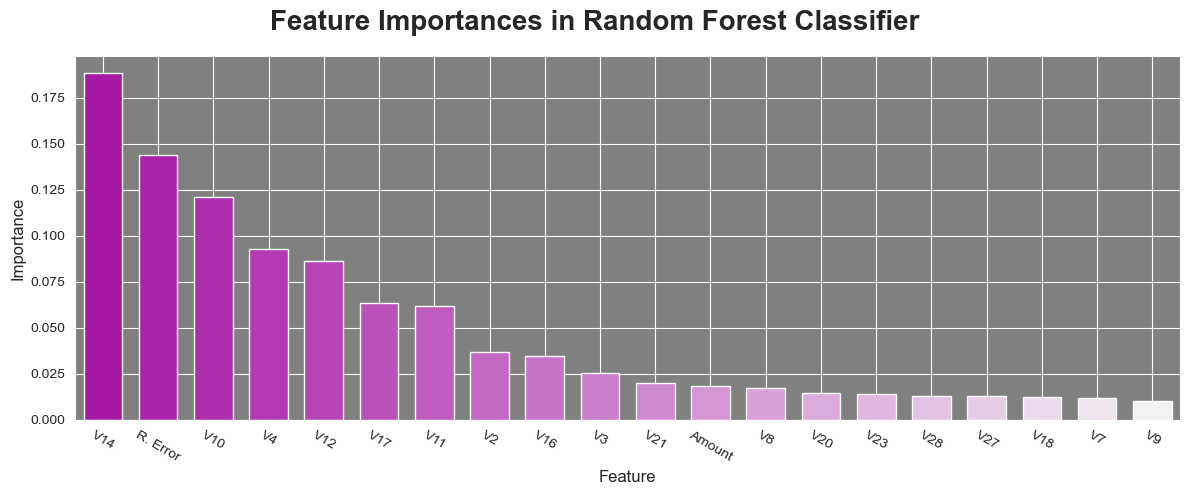

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
index = datamodel.drop(columns='Class').columns[rfc.named_steps['kbest'].get_support()]
importances = pd.DataFrame(data=rfc.named_steps['clf'].feature_importances_, columns=['Feature'], index=index)
importances = importances.reset_index().sort_values(by='Feature', ascending=False).reset_index(drop=True)

sns.barplot(data=importances, x='index', y='Feature', palette='light:m_r', width=0.7)
plt.xlabel('Feature', fontsize=12), plt.ylabel('Importance', fontsize=12)
plt.suptitle('Feature Importances in Random Forest Classifier', fontsize=20, fontweight='bold')
plt.xticks(rotation=-30), plt.grid(), ax.set_facecolor('grey'), plt.tight_layout();

###### SELECTION OF THE BEST DECISION THRESHOLD

In [28]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=4)
ymodelprob = model_selection.cross_val_predict(rfc, Xmodel, ymodel, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
prec, rec, thresholds = metrics.precision_recall_curve(ymodel, ymodelprob)
f1s = 2 * (prec * rec) / (prec + rec + 1e-8)

bestidx = np.argmax(f1s)
bestthresh = thresholds[bestidx]
bestf1 = f1s[bestidx]

print(f'The optimal decision threshold is {bestthresh:.4f}, achieving a maximum F1-score of {bestf1:.4f}')

The optimal decision threshold is 0.3160, achieving a maximum F1-score of 0.8913


###### EVALUATION OF THE MODEL ON THE TRAINING DATASET

In [29]:
ypred = (ymodelprob >= bestthresh).astype(int)
clsrprt = metrics.classification_report(ymodel, ypred, output_dict=True)
reporttrain = pd.DataFrame(clsrprt).transpose()

auprc_train = metrics.average_precision_score(ymodel, ymodelprob)
rocauc_train = metrics.roc_auc_score(ymodel, ymodelprob)
reporttrain.loc['auprc'] = auprc_train
reporttrain.loc['aurocc'] = rocauc_train

table = reporttrain.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Random Forest Classifier Metrics (Train Data)</h3>"))
display(table)

,precision,recall,f1-score,support
0,0.999042,0.999781,0.999412,59483.000000
1,0.956667,0.834302,0.891304,344.000000
accuracy,0.998830,0.998830,0.998830,0.998830
macro avg,0.977855,0.917042,0.945358,59827.000000
weighted avg,0.998799,0.998830,0.998790,59827.000000
auprc,0.872590,0.872590,0.872590,0.872590
aurocc,0.963088,0.963088,0.963088,0.963088


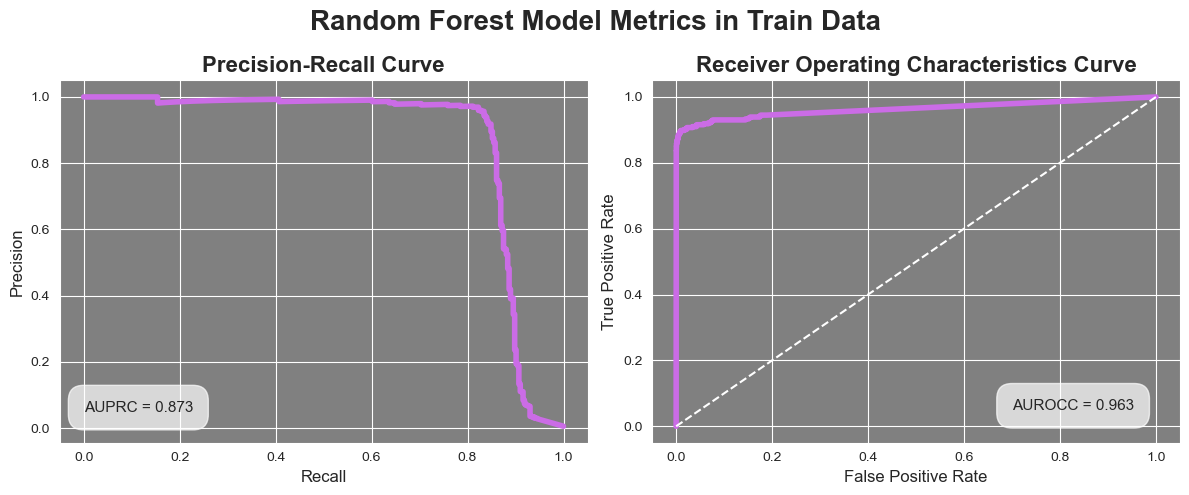

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
prec, rec, _ = metrics.precision_recall_curve(ymodel, ymodelprob)

axs[0].plot(rec, prec, color='#CB6CE6', linewidth=4)
str_text = f'AUPRC = {auprc_train:.3f}'
axs[0].text(0, 0.05, str_text, size=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='w', boxstyle='round,pad=1'))
axs[0].set_xlabel('Recall', size=12), axs[0].set_ylabel('Precision', size=12)
axs[0].set_title('Precision-Recall Curve', size=16, weight='bold')
axs[0].set_facecolor('grey'), axs[0].grid(True)

fpr, tpr, _ = metrics.roc_curve(ymodel, ymodelprob)
axs[1].plot(fpr, tpr, color='#CB6CE6', linewidth=4)
sns.lineplot(x=[0, 1], y=[0, 1], color='white', linestyle='--', ax=axs[1])
str_text = f'AUROCC = {rocauc_train:.3f}'
axs[1].text(0.70, 0.05, str_text, fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='w', boxstyle='round,pad=1'))
axs[1].set_xlabel('False Positive Rate', size=12), axs[1].set_ylabel('True Positive Rate', size=12)
axs[1].set_title('Receiver Operating Characteristics Curve', size=16, weight='bold')
axs[1].set_facecolor('grey'), axs[1].grid(True)

plt.suptitle('Random Forest Model Metrics in Train Data', size=20, weight='bold')
plt.tight_layout();

The model, on the training data, **detects 83,4% of actual fraud cases (287 out of 344)**, which is equivalent to **intercepting approximately 5 out of every 6 fraud attempts**. This indicates that the system is effective at preventing financial losses, as it successfully identifies the vast majority of malicious transactions.

At the same time, **only 13 out of nearly 60,000 legitimate transactions** were incorrectly classified as fraud. This means the model inconveniences **fewer than 1 legitimate customer for every 4,500 valid transactions**, an extremely low false positive rate for a production-grade detection system.

In other words, the model achieves **excellent fraud control with minimal impact on customer experience**: it protects without interfering.

Furthermore, it maintains consistent behavior. For each transaction flagged as fraud by the system, there is a high likelihood (around 95%) that it truly is fraudulent. This significantly reduces operational workload and the need for manual review of large volumes of false positives.

From a practical standpoint, the model demonstrates **high real-world effectiveness**: it reliably safeguards the financial system without significantly penalizing legitimate users, striking a solid balance between security and operational effciency.


#### 5. EVALUATION

##### FINAL EVALUATION OF THE MODEL ON THE TEST DATASET

In [31]:
# Data preprocessing pipeline
def data_preprocessing(X):
    lowercolumns = [col.lower() for col in X.columns]
    if 'time' in lowercolumns:
        idx = lowercolumns.index('time')
        X = X.drop(X.columns[idx], axis=1)  ## 0. Drop «Time» column
    if 'Amount' in X.columns:
        X['Amount'] = qtt.transform(X[['Amount']]) ## 1. Quantile transformation in «Amount»
    
    Xfinal = mms.transform(X)  ## 2. Min-Max normalization
    Xencoded = autoencoder.encoder(Xfinal)
    Xdecoded = autoencoder.decoder(Xencoded)  ## 3. Autoencoder reconstruction
    
    Rerror = np.mean(np.square(Xfinal - Xdecoded), axis=1).reshape(-1, 1)  ## 4. Reconstruction error
    Xfinal = np.concatenate([Xdecoded, Rerror], axis=1)  ## 5. Final data (Autoencoder output + r. error)
    
    return Xfinal ## This output is ready to use in Random Forest Classifier
    
X, yfinal = pd.concat([X0val, X1val]), pd.concat([y0val, y1val]) ## Concatenate only in this case
Xfinal = data_preprocessing(X)

In [32]:
yprob = rfc.predict_proba(Xfinal)[:, 1]
ypred = (yprob >= bestthresh).astype(int)
clsrprt = metrics.classification_report(yfinal, ypred, output_dict=True)
reporttest = pd.DataFrame(clsrprt).transpose()

auprc_test = metrics.average_precision_score(yfinal, yprob)
rocauc_test = metrics.roc_auc_score(yfinal, yprob)
reporttest.loc['auprc'] = auprc_test
reporttest.loc['aurocc'] = rocauc_test

table = reporttest.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Random Forest Classifier Metrics (Test Data)</h3>"))
display(table)

,precision,recall,f1-score,support
0,0.999020,0.999686,0.999353,25493.000000
1,0.938931,0.831081,0.881720,148.000000
accuracy,0.998713,0.998713,0.998713,0.998713
macro avg,0.968976,0.915384,0.940537,25641.000000
weighted avg,0.998673,0.998713,0.998674,25641.000000
auprc,0.894131,0.894131,0.894131,0.894131
aurocc,0.977132,0.977132,0.977132,0.977132


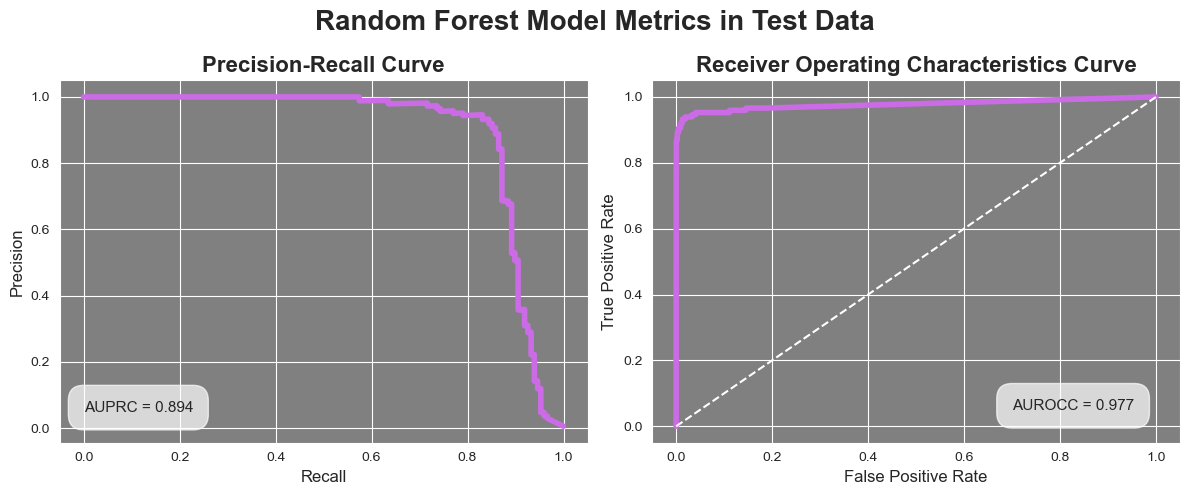

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
prec, rec, _ = metrics.precision_recall_curve(yfinal, yprob)

axs[0].plot(rec, prec, color='#CB6CE6', linewidth=4)
str_text = f'AUPRC = {auprc_test:.3f}'
axs[0].text(0, 0.05, str_text, size=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='w', boxstyle='round,pad=1'))
axs[0].set_xlabel('Recall', size=12), axs[0].set_ylabel('Precision', size=12)
axs[0].set_title('Precision-Recall Curve', size=16, weight='bold')
axs[0].set_facecolor('grey'), axs[0].grid(True)

fpr, tpr, _ = metrics.roc_curve(yfinal, yprob)
axs[1].plot(fpr, tpr, color='#CB6CE6', linewidth=4)
sns.lineplot(x=[0, 1], y=[0, 1], color='white', linestyle='--', ax=axs[1])
str_text = f'AUROCC = {rocauc_test:.3f}'
axs[1].text(0.70, 0.05, str_text, fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='w', boxstyle='round,pad=1'))
axs[1].set_xlabel('False Positive Rate', size=12), axs[1].set_ylabel('True Positive Rate', size=12)
axs[1].set_title('Receiver Operating Characteristics Curve', size=16, weight='bold')
axs[1].set_facecolor('grey'), axs[1].grid(True)

plt.suptitle('Random Forest Model Metrics in Test Data', size=20, weight='bold')
plt.tight_layout();

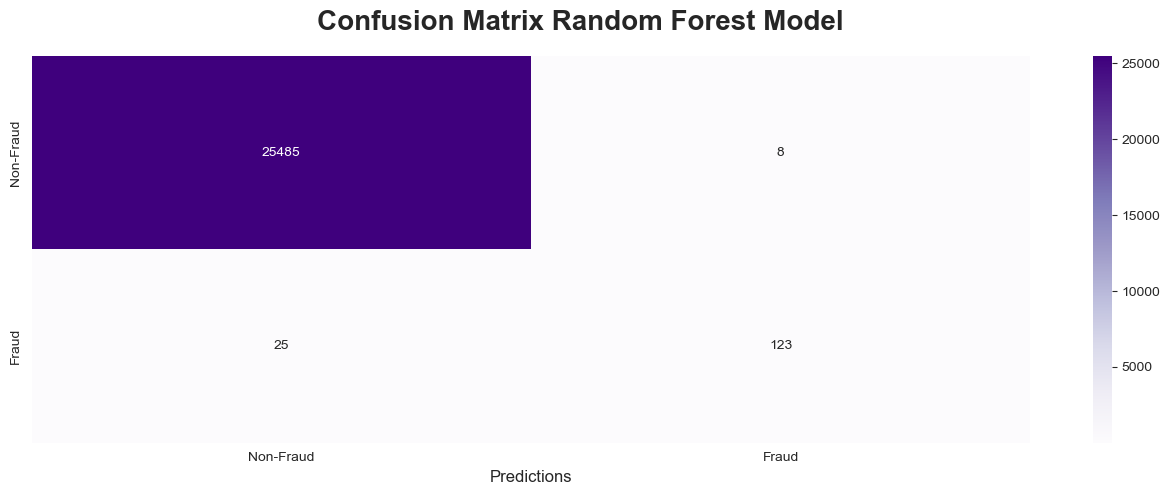

In [34]:
fig, ax = plt.subplots(figsize=(13, 5))
cm = metrics.confusion_matrix(yfinal, ypred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predictions', fontsize=12), plt.ylabel(None)
plt.suptitle('Confusion Matrix Random Forest Model', fontsize=20, fontweight='bold', x=0.45), plt.tight_layout();

On the test data, the model **correctly detects 84% of fraudulent transactions (125 out of 148)**, meaning that, on average, **it identifies about 5 out of every 6 actual frauds**. This reflects the model's real-world ability to continue intercepting fraud attempts under new and varied conditions.

It commits **only 8 false positives among more than 25,000 legitimate transactions**, which means that **a legitimate customer is mistakenly interrupted in approximately 1 out of every 3,200 valid transactions**. This level of accuracy minimizes operational and commercial impact on the user experience.

For each transaction flagged by the model as potential fraud, **over 93,8% are indeed fraudulent**, indicating that the system remains highly reliable in prioritizing alerts that truly require investigation or action.

The **AUPRC of 0.894** supports this behavior by demonstrating that the model maintains excellent discriminative power for the positive class (fraud) in unseen data. This metric suggests that the quality of the fraud probability ranking remains high.

The **F1-score of 0.882** for the fraudulent class confirms that the balance between detecting fraud and avoiding false alarms remains effective, even outside the training set.

In summary, the model shows **consistent and practical performance on test data**, with a high fraud detection rate and a very low false positive rate. This enables reliable deployment in a real-world system, delivering strong preventive value for the organization with minimal impact on legitimate customers.

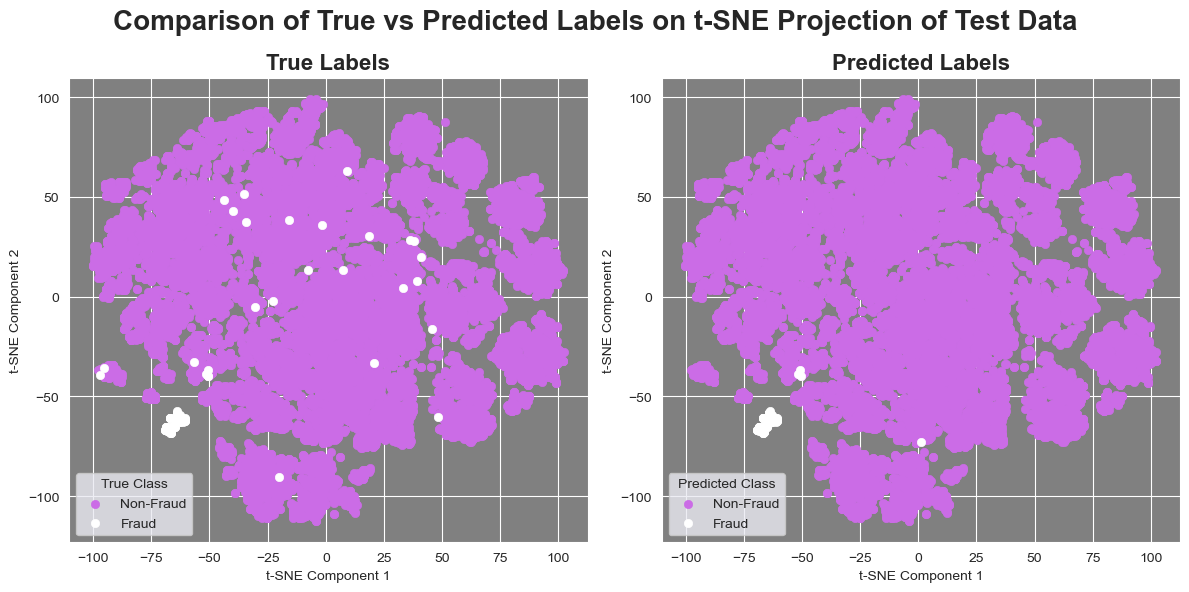

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
tsnedata = pd.DataFrame(tsne.fit_transform(Xfinal), columns=['t-SNE Component 1', 't-SNE Component 2'])
tsnedata['True'], tsnedata['Pred'] = yfinal.values, ypred
testtrue0, testtrue1 = tsnedata[tsnedata['True'] == 0], tsnedata[tsnedata['True'] == 1]
testpred0, testpred1 = tsnedata[tsnedata['Pred'] == 0], tsnedata[tsnedata['Pred'] == 1]

huefinal = pd.Series(yfinal).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=testtrue0['t-SNE Component 1'], y=testtrue0['t-SNE Component 2'], color='#CB6CE6', edgecolor=None, ax=axs[0], label='Non-Fraud')
sns.scatterplot(x=testtrue1['t-SNE Component 1'], y=testtrue1['t-SNE Component 2'], color='white', edgecolor=None, ax=axs[0], label='Fraud')
axs[0].set_title('True Labels', fontsize=16, fontweight='bold')
axs[0].set_facecolor('grey'), axs[0].grid(), axs[0].legend(title='True Class')

huepred = pd.Series(ypred).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=testpred0['t-SNE Component 1'], y=testpred0['t-SNE Component 2'], color='#CB6CE6', edgecolor=None, ax=axs[1], label='Non-Fraud')
sns.scatterplot(x=testpred1['t-SNE Component 1'], y=testpred1['t-SNE Component 2'], color='white', edgecolor=None, ax=axs[1], label='Fraud')
axs[1].set_title('Predicted Labels', fontsize=16, fontweight='bold')
axs[1].set_facecolor('grey'), axs[1].grid(), axs[1].legend(title='Predicted Class')

fig.suptitle('Comparison of True vs Predicted Labels on t-SNE Projection of Test Data', fontsize=20, fontweight='bold'), plt.tight_layout();

The visual analysis using t-SNE projection on the test set provides a clearer understanding of the model’s spatial behavior. In the plot, a group of fraudulent transactions appears clearly separated from the rest, indicating that there are distinctive patterns the model successfully captures with high effectiveness. This separation is largely the result of preprocessing through the autoencoder, which has reduced the complexity of the feature space and facilitated the discrimination of atypical frauds.

However, a considerable number of fraudulent cases are dispersed among legitimate transactions without a clear boundary. These typically correspond to more sophisticated frauds or ones deliberately designed to mimic the behavior of legitimate users, making them harder to detect. In those regions, the model struggles to distinguish between classes, which results in some false negatives.

In summary, the model performs well in detecting frauds that are structurally different from normal activity but faces challenges when fraudulent behavior closely resembles that of legitimate users. This reflects the common limitations faced in real-world fraud detection scienarios.

##### COMPARISON OF METRICS AND FINAL CONCLUSIONS

In [36]:
reportfinal = (reporttest - reporttrain).drop('support', axis=1)
table = reportfinal.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Random Forest Classifier Metrics (Test Data - Train Data)</h3>"))
display(table)

,precision,recall,f1-score
0,-0.000022,-0.000095,-0.000059
1,-0.017735,-0.003221,-0.009584
accuracy,-0.000117,-0.000117,-0.000117
macro avg,-0.008879,-0.001658,-0.004821
weighted avg,-0.000126,-0.000117,-0.000116
auprc,0.021540,0.021540,0.021540
aurocc,0.014044,0.014044,0.014044


The model shows **minimal difference between training and test performance**, indicating that it **generalizes well and is neither underfitting nor overfitting**. For the fraudulent class, precision drops by only \~1.8%, recall by \~0.3%, and F1-score by \~1.0%. These are small, expected variations in real-world scenarios. For the legitimate class, the metrics remain virtually unchanged. The **AUPRC** increases by **0.0215 points**, and the **AUROCC** by **0.0140**, confirming that the model maintains strong discriminative power on unseen data.

***Conclusion***: The proposed model demonstrates **strong** and **consistent** performance, highlighting its ability to detect fraud without compromising stability. Optimizing the decision threshold enabled an **effective balance between precision and recall**, ensuring the model is not only efficient but also cautious when generating alerts.

Thanks to the use of an autoencoder, a more compact and meaningful representation of the feature space was achieved, facilitating the detection of frauds that are structurally different from normal behavior. However, the model still faces limitations when fraud attempts closely mimic legitimate transactions, reflecting the inherent complexity of the problem and the need for complementary techniques to cover more subtle cases.

Overall, the model is highly functional for real-world environments seeking an automated, interpretable, and scalable solution. While not infallible, its results are robust enough to be implemented as part of a hybrid fraud prevention system, especially when combined with human supervision or additional early detection modules.

#### 6. REFERENCES

***Autoencoder***
* [TensorFlow](https://www.tensorflow.org/tutorials/generative/autoencoder?hl=es-419)
* [GeeksforGeeks](https://www.geeksforgeeks.org/auto-encoders/)
* [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)
* [arXiv](https://arxiv.org/abs/2201.03898)

***SelectKBest***
* [Scikit-learn (SelectKBest)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
* [Scikit-learn (mutual_info_classif)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

***Random Forest Classifier***
* [Scikit-learn (Random Forest)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [GeeksforGeeks (Random Forest)](https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/)
* [Built In (Random Forest)](https://builtin.com/data-science/random-forest-algorithm)

***Reference projects***
* [Credit Card Fraud Detection with RF (AUC=0.93)](https://www.kaggle.com/code/gpreda/credit-card-fraud-detection-with-rf-auc-0-93#input-data)
* [Imbalanced data & why you should NOT use ROC curve](https://www.kaggle.com/code/lct14558/imbalanced-data-why-you-should-not-use-roc-curve)
* [In depth skewed data classif. (93% recall acc now)](https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now)
* [The autoencoder says that data is different](https://www.kaggle.com/code/tilii7/the-autoencoder-says-that-data-is-different)
* [Semi Supervised Classification using AutoEncoders](https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders#2.-Visualize-Fraud-and-NonFraud-Transactions)
* [Credit Fraud || Dealing with Imbalanced Datasets](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook#Overfitting-during-Cross-Validation)
* [Best techniques and metrics for Imbalanced Dataset](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset#3.5-99,8%25-Accuracy-score-before-implementing-any-model)
* [EDA WITHIN SNAP OF FINGERS!!!](https://www.kaggle.com/code/nareshbhat/eda-within-snap-of-fingers)
* [How Autoencoders Work: Intro and UseCases](https://www.kaggle.com/code/shivamb/how-autoencoders-work-intro-and-usecases)

#### 7. LICENCE AND FINAL NOTE FROM THE AUTHOR

**License**

The content of this project (including the technical report and source code) is distributed under open licenses that promote reuse and knowledge sharing. The report is covered by the [**Creative Commons Attribution 4.0 International (CC BY 4.0)**](https://creativecommons.org/licenses/by/4.0/) license, which allows for sharing and adaptation of the material, even for commercial purposes, as long as appropriate credit is given to the author. The source code is released under the [**MIT License**](https://opensource.org/license/MIT), granting the freedom to use, modify, and redistribute the code under the condition that the original authorship notice is retained. Please note that while the content may be freely used, the use of the name **"Caio Quinamo Analytics Solutions"**, its logo, or any other identifying elements is restricted unless prior written permission is granted.

**Final Note from the Author**

This work represents not only a technical effort but also an open invitation to collaborate, provide critical analysis, and engage in shared learning. The author deeply appreciates anyone who takes the time to review, comment on, or adapt this project. All contributions (be they suggestions, constructive criticism, or alternative perspectives) are welcome and valued, as they help refine the proposed approach and enrich the discussion around the challenges addressed. This project will continue to evolve, driven by open dialogue and a commitment to building increasingly robust and accessible solutions for the community.

Thank you for your atention.